In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
import os
import matplotlib.pyplot as plt

In [2]:
# For reproducible results
np.random.seed(0)

In [3]:
# Load the the csv file (healthcare-dataset-stroke-data.csv)
Stroke_address = '/Users/francybayona/Documents/DOC DIEGO/Python docs/Stroke_Prediction/healthcare-dataset-stroke-data.csv'
df_Stroke = pd.read_csv(Stroke_address)
df_Stroke.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [4]:
# Fill NaN values for the bmi column
df_Stroke_edited = df_Stroke.fillna({'bmi':df_Stroke['bmi'].mean()})
df_Stroke_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
#Define train and target for TabNet
#Drop columns that are not part of the analysis: id
train = df_Stroke_edited.drop(['id'],axis='columns')
target = 'stroke'

In [6]:
#Define the number of folds for the outer cross-validation
outer_cv_folds = 5

In [7]:
# Initialize probability variables for XGBoost
prob_train_XGBoost = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_XGBoost = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_XGBoost = np.full(outer_cv_folds, np.nan)
aucs_test_XGBoost = np.full(outer_cv_folds, np.nan)

In [8]:
# Initialize probability variables for RandomForestClassifier
prob_train_RFC = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_RFC = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_RFC = np.full(outer_cv_folds, np.nan)
aucs_test_RFC = np.full(outer_cv_folds, np.nan)

In [9]:
# Initialize probability variables for Support Vector Machine
prob_train_SVM = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_SVM = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_SVM  = np.full(outer_cv_folds, np.nan)
aucs_test_SVM  = np.full(outer_cv_folds, np.nan)

In [10]:
# Initialize probability variables for LogisticRegression
prob_train_LogR = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_LogR = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_LogR = np.full(outer_cv_folds, np.nan)
aucs_test_LogR = np.full(outer_cv_folds, np.nan)

In [11]:
# Initialize probability variables for Single Decision Tree Classifier
prob_train_SDTree = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_SDTree = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_SDTree = np.full(outer_cv_folds, np.nan)
aucs_test_SDTree = np.full(outer_cv_folds, np.nan)

In [12]:
# Initialize probability variables for TabNet
prob_train_TabNet = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
prob_test_TabNet = np.full((np.shape(train)[0], outer_cv_folds), np.nan)
aucs_train_TabNet = np.full(outer_cv_folds, np.nan)
aucs_test_TabNet = np.full(outer_cv_folds, np.nan)

In [13]:
# Use the function LabelEncoder 
train['gender'] = LabelEncoder().fit_transform(train['gender'])
train['ever_married'] = LabelEncoder().fit_transform(train['ever_married'])
train['work_type'] = LabelEncoder().fit_transform(train['work_type'])
train['Residence_type'] = LabelEncoder().fit_transform(train['Residence_type'])
train['smoking_status'] = LabelEncoder().fit_transform(train['smoking_status'])
#Separate variables (x) from target (y) 
x =  train.drop(['stroke'],axis='columns')
y = train.stroke

In [14]:
#Outer cross validation
cv_outer = StratifiedKFold(n_splits=outer_cv_folds)
ncv_idx = -1

for train_idx, test_idx in cv_outer.split(x, y):
    ncv_idx += 1
    train_data, test_data = x.iloc[train_idx], x.iloc[test_idx]
    train_target, test_target = y.iloc[train_idx], y.iloc[test_idx]
    XGBoost_model = XGBClassifier(objective = 'binary:logistic', # Add objective and metric to model initialization
                                  eval_metric = 'auc')
    RFC_model = RandomForestClassifier()
    SVM_model = SVC(probability=True)
    LogR_model = LogisticRegression()
    SDTree_model = tree.DecisionTreeClassifier()
    # Find best XGBoost parameters
    cv_inner = StratifiedKFold(n_splits=3)   # Training data being split 3 times 
    Parmt_XGBoost = {'n_estimators':[50, 100],
                     'max_depth':[3, 5],
                     'learning_rate':[0.01, 0.1, 0.3],
                     'colsample_bytree':[0.5, 1],
                     'gamma':[0],
                     }
    
    Parmt_model_XGBoost = GridSearchCV(estimator=XGBoost_model,
                                       param_grid=Parmt_XGBoost,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_XGBoost = Parmt_model_XGBoost.best_params_
    # Set best parameters to XGBoost and Tabnet model
    XGBoost_model.set_params(**best_parameters_XGBoost)
    # Train optimized XGBoost model on train data
    XGBoost_model.fit(train_data,train_target)
    # Train data results
    prob_train_XGBoost[train_idx, ncv_idx] = XGBoost_model.predict_proba(train_data)[:,1]
    aucs_train_XGBoost[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_XGBoost[train_idx, ncv_idx])
    # Test data results
    prob_test_XGBoost[test_idx, ncv_idx] = XGBoost_model.predict_proba(test_data)[:,1]
    aucs_test_XGBoost[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_XGBoost[test_idx, ncv_idx])
    
    # Find best RandomForestClassifier parameters
    Parmt_RFC = {'criterion':['gini','entropy'], 'max_depth':[1,10,100,1000],
               'class_weight':['balanced',None]}
    Parmt_model_RFC = GridSearchCV(estimator=RFC_model,
                                       param_grid=Parmt_RFC,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_RFC = Parmt_model_RFC.best_params_
    # Set best parameters to RFC
    RFC_model.set_params(**best_parameters_RFC)
    # Train optimized RFC model on train data
    RFC_model.fit(train_data,train_target)
    # Train data results
    prob_train_RFC[train_idx, ncv_idx] = RFC_model.predict_proba(train_data)[:,1]
    aucs_train_RFC[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_RFC[train_idx, ncv_idx])
    # Test data results
    prob_test_RFC[test_idx, ncv_idx] = RFC_model.predict_proba(test_data)[:,1]
    aucs_test_RFC[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_RFC[test_idx, ncv_idx])
    
    # Find best Suport Vector Machine parameters
    Parmt_SVM = {'C':[1,10,100], 'class_weight':['balanced',None], 'coef0':[0,1,10],
             'decision_function_shape':['ovo','ovr'], 'gamma':['scale','auto'],
             'kernel':['rbf'],'max_iter':[-1,1000]}
    Parmt_model_SVM = GridSearchCV(estimator=SVM_model,
                                       param_grid=Parmt_SVM,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_SVM = Parmt_model_SVM.best_params_
    # Set best parameters to SVM
    SVM_model.set_params(**best_parameters_SVM)
    # Train optimized SVM model on train data
    SVM_model.fit(train_data,train_target)
    # Train data results
    prob_train_SVM[train_idx, ncv_idx] = SVM_model.predict_proba(train_data)[:,1]
    aucs_train_SVM[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_SVM[train_idx, ncv_idx])
    # Test data results
    prob_test_SVM[test_idx, ncv_idx] = SVM_model.predict_proba(test_data)[:,1]
    aucs_test_SVM[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_SVM[test_idx, ncv_idx])
    
    # Find best Suport Logistic Regression
    Parmt_LogR = {'C':[1,10,100], 'class_weight':['balanced',None], 'dual':[False],
              'fit_intercept':[True,False], 'intercept_scaling':[1,10,100], 'penalty':['l2'],
              'multi_class':['auto','ovr','multinomial'],'max_iter':[1000]}
    Parmt_model_LogR = GridSearchCV(estimator=LogR_model,
                                       param_grid=Parmt_LogR,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_LogR = Parmt_model_LogR.best_params_
    # Set best parameters to LogR
    LogR_model.set_params(**best_parameters_LogR)
    # Train optimized LogR model on train data
    LogR_model.fit(train_data,train_target)
    # Train data results
    prob_train_LogR[train_idx, ncv_idx] = LogR_model.predict_proba(train_data)[:,1]
    aucs_train_LogR[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_LogR[train_idx, ncv_idx])
    # Test data results
    prob_test_LogR[test_idx, ncv_idx] = LogR_model.predict_proba(test_data)[:,1]
    aucs_test_LogR[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_LogR[test_idx, ncv_idx])
    
    # Find best Suport Single Decision Tree Classifier
    Parmt_SDTree = {'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':[1,10,100,1000],
               'class_weight':['balanced',None], 'max_features':['auto','sqrt','log2'],
               'min_samples_leaf':[1,10,100], 'min_samples_split':[2,4,8], 'min_weight_fraction_leaf':[0.0,0.1,0.5]}
    Parmt_model_SDTree = GridSearchCV(estimator=SDTree_model,
                                       param_grid=Parmt_SDTree,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_SDTree = Parmt_model_SDTree.best_params_
    # Set best parameters to SDTree
    SDTree_model.set_params(**best_parameters_SDTree)
    # Train optimized SDTree model on train data
    SDTree_model.fit(train_data,train_target)
    # Train data results
    prob_train_SDTree[train_idx, ncv_idx] = SDTree_model.predict_proba(train_data)[:,1]
    aucs_train_SDTree[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_SDTree[train_idx, ncv_idx])
    # Test data results
    prob_test_SDTree[test_idx, ncv_idx] = SDTree_model.predict_proba(test_data)[:,1]
    aucs_test_SDTree[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_SDTree[test_idx, ncv_idx])
    
    # Find best TabNet parameters
    TabNet_model = TabNetClassifier(cat_idxs=[])
    
    TabNet_model.fit(X_train=train_data.to_numpy(),  
            y_train=train_target.to_numpy(), 
            eval_set=[(train_data.to_numpy(), train_target.to_numpy())], 
            eval_name=['train'], 
            eval_metric=['auc'],
            max_epochs=2000, 
            patience=2000,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False)

    # Train data results
    prob_train_TabNet[train_idx, ncv_idx] = TabNet_model.predict_proba(train_data.to_numpy())[:,1]
    aucs_train_TabNet[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_TabNet[train_idx, ncv_idx])
    # Test data results
    prob_test_TabNet[test_idx, ncv_idx] = TabNet_model.predict_proba(test_data.to_numpy())[:,1]
    aucs_test_TabNet[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_TabNet[test_idx, ncv_idx])

Device used : cpu
epoch 0  | loss: 0.39279 | train_auc: 0.35659 |  0:00:00s
epoch 1  | loss: 0.20175 | train_auc: 0.38866 |  0:00:00s
epoch 2  | loss: 0.20259 | train_auc: 0.43299 |  0:00:01s
epoch 3  | loss: 0.19554 | train_auc: 0.43979 |  0:00:01s
epoch 4  | loss: 0.18492 | train_auc: 0.44348 |  0:00:02s
epoch 5  | loss: 0.17767 | train_auc: 0.47938 |  0:00:02s
epoch 6  | loss: 0.17996 | train_auc: 0.512   |  0:00:03s
epoch 7  | loss: 0.17681 | train_auc: 0.55755 |  0:00:03s
epoch 8  | loss: 0.17521 | train_auc: 0.59297 |  0:00:04s
epoch 9  | loss: 0.17311 | train_auc: 0.60266 |  0:00:04s
epoch 10 | loss: 0.17157 | train_auc: 0.61778 |  0:00:05s
epoch 11 | loss: 0.16841 | train_auc: 0.62834 |  0:00:05s
epoch 12 | loss: 0.16911 | train_auc: 0.64202 |  0:00:05s
epoch 13 | loss: 0.16847 | train_auc: 0.66125 |  0:00:06s
epoch 14 | loss: 0.16449 | train_auc: 0.66929 |  0:00:06s
epoch 15 | loss: 0.16294 | train_auc: 0.66476 |  0:00:07s
epoch 16 | loss: 0.15916 | train_auc: 0.65588 |  0:00:

epoch 141| loss: 0.13657 | train_auc: 0.91365 |  0:01:03s
epoch 142| loss: 0.1353  | train_auc: 0.91196 |  0:01:04s
epoch 143| loss: 0.13475 | train_auc: 0.92104 |  0:01:04s
epoch 144| loss: 0.13203 | train_auc: 0.92037 |  0:01:05s
epoch 145| loss: 0.13096 | train_auc: 0.92073 |  0:01:05s
epoch 146| loss: 0.13022 | train_auc: 0.91671 |  0:01:06s
epoch 147| loss: 0.13068 | train_auc: 0.91672 |  0:01:06s
epoch 148| loss: 0.13075 | train_auc: 0.91487 |  0:01:07s
epoch 149| loss: 0.13459 | train_auc: 0.91873 |  0:01:07s
epoch 150| loss: 0.13459 | train_auc: 0.92158 |  0:01:08s
epoch 151| loss: 0.13234 | train_auc: 0.92353 |  0:01:08s
epoch 152| loss: 0.13602 | train_auc: 0.91267 |  0:01:08s
epoch 153| loss: 0.13324 | train_auc: 0.91727 |  0:01:09s
epoch 154| loss: 0.13539 | train_auc: 0.91386 |  0:01:09s
epoch 155| loss: 0.13266 | train_auc: 0.91818 |  0:01:10s
epoch 156| loss: 0.13712 | train_auc: 0.9181  |  0:01:10s
epoch 157| loss: 0.13113 | train_auc: 0.92159 |  0:01:11s
epoch 158| los

epoch 283| loss: 0.1207  | train_auc: 0.95082 |  0:02:05s
epoch 284| loss: 0.11742 | train_auc: 0.95078 |  0:02:06s
epoch 285| loss: 0.11565 | train_auc: 0.95212 |  0:02:06s
epoch 286| loss: 0.11526 | train_auc: 0.95253 |  0:02:06s
epoch 287| loss: 0.11392 | train_auc: 0.95339 |  0:02:07s
epoch 288| loss: 0.11584 | train_auc: 0.95444 |  0:02:07s
epoch 289| loss: 0.11348 | train_auc: 0.95779 |  0:02:08s
epoch 290| loss: 0.11257 | train_auc: 0.95614 |  0:02:08s
epoch 291| loss: 0.11116 | train_auc: 0.95291 |  0:02:09s
epoch 292| loss: 0.11128 | train_auc: 0.95543 |  0:02:09s
epoch 293| loss: 0.11288 | train_auc: 0.95449 |  0:02:09s
epoch 294| loss: 0.11397 | train_auc: 0.95364 |  0:02:10s
epoch 295| loss: 0.11589 | train_auc: 0.95057 |  0:02:10s
epoch 296| loss: 0.11589 | train_auc: 0.94896 |  0:02:11s
epoch 297| loss: 0.12063 | train_auc: 0.93595 |  0:02:11s
epoch 298| loss: 0.12514 | train_auc: 0.93848 |  0:02:12s
epoch 299| loss: 0.1218  | train_auc: 0.93576 |  0:02:12s
epoch 300| los

epoch 425| loss: 0.11601 | train_auc: 0.95373 |  0:03:06s
epoch 426| loss: 0.11347 | train_auc: 0.95559 |  0:03:06s
epoch 427| loss: 0.11511 | train_auc: 0.95487 |  0:03:06s
epoch 428| loss: 0.11172 | train_auc: 0.94785 |  0:03:07s
epoch 429| loss: 0.1183  | train_auc: 0.94543 |  0:03:07s
epoch 430| loss: 0.11973 | train_auc: 0.94386 |  0:03:08s
epoch 431| loss: 0.11841 | train_auc: 0.94608 |  0:03:08s
epoch 432| loss: 0.11521 | train_auc: 0.94671 |  0:03:09s
epoch 433| loss: 0.11905 | train_auc: 0.94645 |  0:03:09s
epoch 434| loss: 0.11395 | train_auc: 0.93717 |  0:03:10s
epoch 435| loss: 0.12742 | train_auc: 0.92543 |  0:03:10s
epoch 436| loss: 0.12824 | train_auc: 0.92157 |  0:03:10s
epoch 437| loss: 0.12789 | train_auc: 0.93059 |  0:03:11s
epoch 438| loss: 0.12366 | train_auc: 0.9377  |  0:03:11s
epoch 439| loss: 0.12234 | train_auc: 0.94384 |  0:03:12s
epoch 440| loss: 0.11894 | train_auc: 0.94583 |  0:03:12s
epoch 441| loss: 0.118   | train_auc: 0.9479  |  0:03:12s
epoch 442| los

epoch 567| loss: 0.11689 | train_auc: 0.94782 |  0:04:06s
epoch 568| loss: 0.11428 | train_auc: 0.94794 |  0:04:06s
epoch 569| loss: 0.11526 | train_auc: 0.94302 |  0:04:07s
epoch 570| loss: 0.12315 | train_auc: 0.9475  |  0:04:07s
epoch 571| loss: 0.11254 | train_auc: 0.95125 |  0:04:08s
epoch 572| loss: 0.11062 | train_auc: 0.95513 |  0:04:08s
epoch 573| loss: 0.11277 | train_auc: 0.95569 |  0:04:09s
epoch 574| loss: 0.10976 | train_auc: 0.95502 |  0:04:09s
epoch 575| loss: 0.11116 | train_auc: 0.95659 |  0:04:10s
epoch 576| loss: 0.1083  | train_auc: 0.95693 |  0:04:10s
epoch 577| loss: 0.11404 | train_auc: 0.95655 |  0:04:10s
epoch 578| loss: 0.1118  | train_auc: 0.95867 |  0:04:11s
epoch 579| loss: 0.1079  | train_auc: 0.96045 |  0:04:11s
epoch 580| loss: 0.11101 | train_auc: 0.95993 |  0:04:12s
epoch 581| loss: 0.10802 | train_auc: 0.96218 |  0:04:12s
epoch 582| loss: 0.10741 | train_auc: 0.96202 |  0:04:12s
epoch 583| loss: 0.10853 | train_auc: 0.96272 |  0:04:13s
epoch 584| los

epoch 709| loss: 0.12224 | train_auc: 0.93401 |  0:05:07s
epoch 710| loss: 0.12218 | train_auc: 0.93935 |  0:05:07s
epoch 711| loss: 0.11786 | train_auc: 0.94319 |  0:05:07s
epoch 712| loss: 0.11772 | train_auc: 0.94646 |  0:05:08s
epoch 713| loss: 0.11693 | train_auc: 0.9474  |  0:05:08s
epoch 714| loss: 0.11418 | train_auc: 0.94882 |  0:05:09s
epoch 715| loss: 0.11331 | train_auc: 0.95163 |  0:05:09s
epoch 716| loss: 0.10998 | train_auc: 0.95416 |  0:05:10s
epoch 717| loss: 0.10749 | train_auc: 0.95416 |  0:05:10s
epoch 718| loss: 0.11383 | train_auc: 0.95076 |  0:05:11s
epoch 719| loss: 0.12161 | train_auc: 0.93909 |  0:05:11s
epoch 720| loss: 0.12505 | train_auc: 0.93438 |  0:05:11s
epoch 721| loss: 0.12258 | train_auc: 0.93731 |  0:05:12s
epoch 722| loss: 0.12057 | train_auc: 0.94552 |  0:05:12s
epoch 723| loss: 0.11907 | train_auc: 0.94998 |  0:05:13s
epoch 724| loss: 0.1199  | train_auc: 0.95014 |  0:05:13s
epoch 725| loss: 0.115   | train_auc: 0.95122 |  0:05:14s
epoch 726| los

epoch 851| loss: 0.10695 | train_auc: 0.95782 |  0:06:11s
epoch 852| loss: 0.10853 | train_auc: 0.95622 |  0:06:11s
epoch 853| loss: 0.10665 | train_auc: 0.95875 |  0:06:12s
epoch 854| loss: 0.10819 | train_auc: 0.9597  |  0:06:12s
epoch 855| loss: 0.10371 | train_auc: 0.95868 |  0:06:12s
epoch 856| loss: 0.10674 | train_auc: 0.96008 |  0:06:13s
epoch 857| loss: 0.10911 | train_auc: 0.96151 |  0:06:13s
epoch 858| loss: 0.10631 | train_auc: 0.96314 |  0:06:14s
epoch 859| loss: 0.10494 | train_auc: 0.96003 |  0:06:14s
epoch 860| loss: 0.11503 | train_auc: 0.95934 |  0:06:14s
epoch 861| loss: 0.10526 | train_auc: 0.96155 |  0:06:15s
epoch 862| loss: 0.10247 | train_auc: 0.96131 |  0:06:15s
epoch 863| loss: 0.10946 | train_auc: 0.96306 |  0:06:16s
epoch 864| loss: 0.10093 | train_auc: 0.96515 |  0:06:16s
epoch 865| loss: 0.10235 | train_auc: 0.96353 |  0:06:16s
epoch 866| loss: 0.10196 | train_auc: 0.96482 |  0:06:17s
epoch 867| loss: 0.1073  | train_auc: 0.96495 |  0:06:17s
epoch 868| los

epoch 993| loss: 0.08452 | train_auc: 0.98224 |  0:07:10s
epoch 994| loss: 0.0912  | train_auc: 0.98322 |  0:07:10s
epoch 995| loss: 0.08669 | train_auc: 0.98168 |  0:07:11s
epoch 996| loss: 0.08692 | train_auc: 0.98203 |  0:07:11s
epoch 997| loss: 0.09051 | train_auc: 0.9798  |  0:07:12s
epoch 998| loss: 0.08743 | train_auc: 0.9804  |  0:07:12s
epoch 999| loss: 0.08663 | train_auc: 0.98209 |  0:07:13s
epoch 1000| loss: 0.09848 | train_auc: 0.98168 |  0:07:13s
epoch 1001| loss: 0.09105 | train_auc: 0.97968 |  0:07:13s
epoch 1002| loss: 0.09298 | train_auc: 0.98014 |  0:07:14s
epoch 1003| loss: 0.08832 | train_auc: 0.98249 |  0:07:14s
epoch 1004| loss: 0.08835 | train_auc: 0.98287 |  0:07:15s
epoch 1005| loss: 0.08648 | train_auc: 0.98438 |  0:07:15s
epoch 1006| loss: 0.08954 | train_auc: 0.98447 |  0:07:15s
epoch 1007| loss: 0.08651 | train_auc: 0.98338 |  0:07:16s
epoch 1008| loss: 0.08461 | train_auc: 0.98265 |  0:07:16s
epoch 1009| loss: 0.08671 | train_auc: 0.98295 |  0:07:17s
epoc

epoch 1132| loss: 0.06983 | train_auc: 0.98977 |  0:08:08s
epoch 1133| loss: 0.07665 | train_auc: 0.99117 |  0:08:08s
epoch 1134| loss: 0.0749  | train_auc: 0.99044 |  0:08:09s
epoch 1135| loss: 0.08108 | train_auc: 0.98975 |  0:08:09s
epoch 1136| loss: 0.07032 | train_auc: 0.98916 |  0:08:10s
epoch 1137| loss: 0.0819  | train_auc: 0.98828 |  0:08:10s
epoch 1138| loss: 0.07511 | train_auc: 0.98906 |  0:08:10s
epoch 1139| loss: 0.07697 | train_auc: 0.98892 |  0:08:11s
epoch 1140| loss: 0.075   | train_auc: 0.98992 |  0:08:11s
epoch 1141| loss: 0.07568 | train_auc: 0.99113 |  0:08:12s
epoch 1142| loss: 0.07036 | train_auc: 0.99107 |  0:08:12s
epoch 1143| loss: 0.07013 | train_auc: 0.99059 |  0:08:12s
epoch 1144| loss: 0.07432 | train_auc: 0.9908  |  0:08:13s
epoch 1145| loss: 0.07228 | train_auc: 0.99104 |  0:08:13s
epoch 1146| loss: 0.06968 | train_auc: 0.99208 |  0:08:14s
epoch 1147| loss: 0.06786 | train_auc: 0.99238 |  0:08:14s
epoch 1148| loss: 0.07042 | train_auc: 0.99227 |  0:08:1

epoch 1271| loss: 0.0688  | train_auc: 0.99396 |  0:09:06s
epoch 1272| loss: 0.06513 | train_auc: 0.99423 |  0:09:06s
epoch 1273| loss: 0.06327 | train_auc: 0.99439 |  0:09:06s
epoch 1274| loss: 0.06451 | train_auc: 0.99295 |  0:09:07s
epoch 1275| loss: 0.06852 | train_auc: 0.99373 |  0:09:07s
epoch 1276| loss: 0.06859 | train_auc: 0.99406 |  0:09:08s
epoch 1277| loss: 0.06444 | train_auc: 0.99466 |  0:09:08s
epoch 1278| loss: 0.05831 | train_auc: 0.99508 |  0:09:08s
epoch 1279| loss: 0.06225 | train_auc: 0.99533 |  0:09:09s
epoch 1280| loss: 0.0629  | train_auc: 0.98949 |  0:09:09s
epoch 1281| loss: 0.075   | train_auc: 0.98206 |  0:09:10s
epoch 1282| loss: 0.0849  | train_auc: 0.9807  |  0:09:10s
epoch 1283| loss: 0.07698 | train_auc: 0.98407 |  0:09:11s
epoch 1284| loss: 0.07605 | train_auc: 0.98643 |  0:09:11s
epoch 1285| loss: 0.07949 | train_auc: 0.98653 |  0:09:11s
epoch 1286| loss: 0.08001 | train_auc: 0.98617 |  0:09:12s
epoch 1287| loss: 0.08074 | train_auc: 0.98524 |  0:09:1

epoch 1410| loss: 0.06305 | train_auc: 0.99523 |  0:10:04s
epoch 1411| loss: 0.05392 | train_auc: 0.99543 |  0:10:04s
epoch 1412| loss: 0.05856 | train_auc: 0.99633 |  0:10:05s
epoch 1413| loss: 0.0595  | train_auc: 0.99631 |  0:10:05s
epoch 1414| loss: 0.05374 | train_auc: 0.99595 |  0:10:06s
epoch 1415| loss: 0.05887 | train_auc: 0.99577 |  0:10:06s
epoch 1416| loss: 0.05144 | train_auc: 0.99589 |  0:10:07s
epoch 1417| loss: 0.06571 | train_auc: 0.99579 |  0:10:07s
epoch 1418| loss: 0.05515 | train_auc: 0.99612 |  0:10:07s
epoch 1419| loss: 0.05241 | train_auc: 0.99713 |  0:10:08s
epoch 1420| loss: 0.05246 | train_auc: 0.99733 |  0:10:08s
epoch 1421| loss: 0.05235 | train_auc: 0.99715 |  0:10:09s
epoch 1422| loss: 0.04945 | train_auc: 0.99675 |  0:10:09s
epoch 1423| loss: 0.05556 | train_auc: 0.99619 |  0:10:09s
epoch 1424| loss: 0.06024 | train_auc: 0.99498 |  0:10:10s
epoch 1425| loss: 0.06046 | train_auc: 0.99351 |  0:10:10s
epoch 1426| loss: 0.06489 | train_auc: 0.9941  |  0:10:1

epoch 1549| loss: 0.05534 | train_auc: 0.9972  |  0:11:03s
epoch 1550| loss: 0.04582 | train_auc: 0.99667 |  0:11:04s
epoch 1551| loss: 0.05759 | train_auc: 0.99739 |  0:11:04s
epoch 1552| loss: 0.0512  | train_auc: 0.99744 |  0:11:05s
epoch 1553| loss: 0.04802 | train_auc: 0.99771 |  0:11:05s
epoch 1554| loss: 0.05117 | train_auc: 0.99772 |  0:11:06s
epoch 1555| loss: 0.04417 | train_auc: 0.99773 |  0:11:06s
epoch 1556| loss: 0.05096 | train_auc: 0.99793 |  0:11:07s
epoch 1557| loss: 0.04624 | train_auc: 0.99773 |  0:11:07s
epoch 1558| loss: 0.05187 | train_auc: 0.99797 |  0:11:07s
epoch 1559| loss: 0.04282 | train_auc: 0.99805 |  0:11:08s
epoch 1560| loss: 0.04262 | train_auc: 0.9979  |  0:11:08s
epoch 1561| loss: 0.04506 | train_auc: 0.99796 |  0:11:09s
epoch 1562| loss: 0.04325 | train_auc: 0.9983  |  0:11:09s
epoch 1563| loss: 0.04291 | train_auc: 0.99828 |  0:11:09s
epoch 1564| loss: 0.04918 | train_auc: 0.99831 |  0:11:10s
epoch 1565| loss: 0.04856 | train_auc: 0.99739 |  0:11:1

epoch 1688| loss: 0.03949 | train_auc: 0.99845 |  0:12:00s
epoch 1689| loss: 0.04808 | train_auc: 0.99833 |  0:12:01s
epoch 1690| loss: 0.04101 | train_auc: 0.99844 |  0:12:01s
epoch 1691| loss: 0.04904 | train_auc: 0.99819 |  0:12:02s
epoch 1692| loss: 0.04909 | train_auc: 0.99833 |  0:12:02s
epoch 1693| loss: 0.05038 | train_auc: 0.99834 |  0:12:02s
epoch 1694| loss: 0.04424 | train_auc: 0.99788 |  0:12:03s
epoch 1695| loss: 0.04601 | train_auc: 0.99802 |  0:12:03s
epoch 1696| loss: 0.05077 | train_auc: 0.99811 |  0:12:04s
epoch 1697| loss: 0.0524  | train_auc: 0.99828 |  0:12:04s
epoch 1698| loss: 0.04927 | train_auc: 0.99822 |  0:12:04s
epoch 1699| loss: 0.05337 | train_auc: 0.99845 |  0:12:05s
epoch 1700| loss: 0.04562 | train_auc: 0.99814 |  0:12:05s
epoch 1701| loss: 0.04476 | train_auc: 0.99813 |  0:12:06s
epoch 1702| loss: 0.0476  | train_auc: 0.99845 |  0:12:06s
epoch 1703| loss: 0.04334 | train_auc: 0.9982  |  0:12:06s
epoch 1704| loss: 0.04492 | train_auc: 0.99805 |  0:12:0

epoch 1827| loss: 0.04026 | train_auc: 0.99855 |  0:12:54s
epoch 1828| loss: 0.04031 | train_auc: 0.99842 |  0:12:54s
epoch 1829| loss: 0.04208 | train_auc: 0.99889 |  0:12:55s
epoch 1830| loss: 0.03937 | train_auc: 0.99904 |  0:12:55s
epoch 1831| loss: 0.04848 | train_auc: 0.99905 |  0:12:55s
epoch 1832| loss: 0.04447 | train_auc: 0.9986  |  0:12:56s
epoch 1833| loss: 0.04401 | train_auc: 0.99885 |  0:12:56s
epoch 1834| loss: 0.03842 | train_auc: 0.9973  |  0:12:57s
epoch 1835| loss: 0.05422 | train_auc: 0.99725 |  0:12:57s
epoch 1836| loss: 0.05089 | train_auc: 0.99694 |  0:12:57s
epoch 1837| loss: 0.05745 | train_auc: 0.99773 |  0:12:58s
epoch 1838| loss: 0.0506  | train_auc: 0.99804 |  0:12:58s
epoch 1839| loss: 0.04364 | train_auc: 0.99818 |  0:12:59s
epoch 1840| loss: 0.04035 | train_auc: 0.99841 |  0:12:59s
epoch 1841| loss: 0.04806 | train_auc: 0.99851 |  0:12:59s
epoch 1842| loss: 0.04582 | train_auc: 0.9984  |  0:13:00s
epoch 1843| loss: 0.04963 | train_auc: 0.99843 |  0:13:0

epoch 1966| loss: 0.03501 | train_auc: 0.99898 |  0:13:47s
epoch 1967| loss: 0.03801 | train_auc: 0.99875 |  0:13:48s
epoch 1968| loss: 0.03867 | train_auc: 0.99892 |  0:13:48s
epoch 1969| loss: 0.03888 | train_auc: 0.99921 |  0:13:49s
epoch 1970| loss: 0.03923 | train_auc: 0.99928 |  0:13:49s
epoch 1971| loss: 0.03972 | train_auc: 0.99934 |  0:13:49s
epoch 1972| loss: 0.03443 | train_auc: 0.99939 |  0:13:50s
epoch 1973| loss: 0.03278 | train_auc: 0.99938 |  0:13:50s
epoch 1974| loss: 0.03545 | train_auc: 0.99948 |  0:13:50s
epoch 1975| loss: 0.03595 | train_auc: 0.99953 |  0:13:51s
epoch 1976| loss: 0.03429 | train_auc: 0.9994  |  0:13:51s
epoch 1977| loss: 0.03225 | train_auc: 0.99948 |  0:13:52s
epoch 1978| loss: 0.03138 | train_auc: 0.99945 |  0:13:52s
epoch 1979| loss: 0.03173 | train_auc: 0.99936 |  0:13:52s
epoch 1980| loss: 0.03332 | train_auc: 0.99934 |  0:13:53s
epoch 1981| loss: 0.03864 | train_auc: 0.99925 |  0:13:53s
epoch 1982| loss: 0.03539 | train_auc: 0.99924 |  0:13:5

epoch 104| loss: 0.13406 | train_auc: 0.91105 |  0:00:40s
epoch 105| loss: 0.13676 | train_auc: 0.91287 |  0:00:41s
epoch 106| loss: 0.13571 | train_auc: 0.90956 |  0:00:41s
epoch 107| loss: 0.13556 | train_auc: 0.91232 |  0:00:42s
epoch 108| loss: 0.13438 | train_auc: 0.91439 |  0:00:42s
epoch 109| loss: 0.13606 | train_auc: 0.91952 |  0:00:42s
epoch 110| loss: 0.13089 | train_auc: 0.91735 |  0:00:43s
epoch 111| loss: 0.13105 | train_auc: 0.91801 |  0:00:43s
epoch 112| loss: 0.13102 | train_auc: 0.92239 |  0:00:43s
epoch 113| loss: 0.13329 | train_auc: 0.92481 |  0:00:44s
epoch 114| loss: 0.1352  | train_auc: 0.92166 |  0:00:44s
epoch 115| loss: 0.13291 | train_auc: 0.92084 |  0:00:45s
epoch 116| loss: 0.13058 | train_auc: 0.9138  |  0:00:45s
epoch 117| loss: 0.13038 | train_auc: 0.91359 |  0:00:45s
epoch 118| loss: 0.13222 | train_auc: 0.92182 |  0:00:46s
epoch 119| loss: 0.13103 | train_auc: 0.92881 |  0:00:46s
epoch 120| loss: 0.13377 | train_auc: 0.91703 |  0:00:47s
epoch 121| los

epoch 246| loss: 0.12096 | train_auc: 0.93113 |  0:01:35s
epoch 247| loss: 0.12939 | train_auc: 0.9193  |  0:01:36s
epoch 248| loss: 0.13505 | train_auc: 0.91886 |  0:01:36s
epoch 249| loss: 0.1383  | train_auc: 0.92187 |  0:01:36s
epoch 250| loss: 0.13552 | train_auc: 0.92213 |  0:01:37s
epoch 251| loss: 0.1318  | train_auc: 0.91855 |  0:01:37s
epoch 252| loss: 0.13488 | train_auc: 0.91524 |  0:01:38s
epoch 253| loss: 0.13315 | train_auc: 0.9128  |  0:01:38s
epoch 254| loss: 0.13602 | train_auc: 0.91634 |  0:01:38s
epoch 255| loss: 0.13266 | train_auc: 0.92199 |  0:01:39s
epoch 256| loss: 0.13043 | train_auc: 0.923   |  0:01:39s
epoch 257| loss: 0.13131 | train_auc: 0.92204 |  0:01:40s
epoch 258| loss: 0.13609 | train_auc: 0.92124 |  0:01:40s
epoch 259| loss: 0.1326  | train_auc: 0.91296 |  0:01:40s
epoch 260| loss: 0.13779 | train_auc: 0.90674 |  0:01:41s
epoch 261| loss: 0.13896 | train_auc: 0.91069 |  0:01:41s
epoch 262| loss: 0.13642 | train_auc: 0.91613 |  0:01:41s
epoch 263| los

epoch 388| loss: 0.12628 | train_auc: 0.93735 |  0:02:30s
epoch 389| loss: 0.12003 | train_auc: 0.93778 |  0:02:31s
epoch 390| loss: 0.12465 | train_auc: 0.93944 |  0:02:31s
epoch 391| loss: 0.12189 | train_auc: 0.94446 |  0:02:32s
epoch 392| loss: 0.11581 | train_auc: 0.94465 |  0:02:32s
epoch 393| loss: 0.11668 | train_auc: 0.94974 |  0:02:32s
epoch 394| loss: 0.11424 | train_auc: 0.95265 |  0:02:33s
epoch 395| loss: 0.11471 | train_auc: 0.94951 |  0:02:33s
epoch 396| loss: 0.11442 | train_auc: 0.95596 |  0:02:34s
epoch 397| loss: 0.11374 | train_auc: 0.95771 |  0:02:34s
epoch 398| loss: 0.11193 | train_auc: 0.95782 |  0:02:34s
epoch 399| loss: 0.11381 | train_auc: 0.95884 |  0:02:35s
epoch 400| loss: 0.10584 | train_auc: 0.96315 |  0:02:35s
epoch 401| loss: 0.1049  | train_auc: 0.9646  |  0:02:35s
epoch 402| loss: 0.10747 | train_auc: 0.96356 |  0:02:36s
epoch 403| loss: 0.11331 | train_auc: 0.95978 |  0:02:36s
epoch 404| loss: 0.10463 | train_auc: 0.95858 |  0:02:37s
epoch 405| los

epoch 530| loss: 0.09326 | train_auc: 0.97106 |  0:03:25s
epoch 531| loss: 0.09587 | train_auc: 0.97278 |  0:03:26s
epoch 532| loss: 0.09394 | train_auc: 0.97176 |  0:03:26s
epoch 533| loss: 0.09841 | train_auc: 0.97351 |  0:03:26s
epoch 534| loss: 0.09351 | train_auc: 0.97366 |  0:03:27s
epoch 535| loss: 0.09573 | train_auc: 0.97316 |  0:03:27s
epoch 536| loss: 0.09889 | train_auc: 0.97191 |  0:03:28s
epoch 537| loss: 0.09619 | train_auc: 0.9715  |  0:03:28s
epoch 538| loss: 0.09668 | train_auc: 0.97224 |  0:03:28s
epoch 539| loss: 0.09478 | train_auc: 0.97603 |  0:03:29s
epoch 540| loss: 0.09242 | train_auc: 0.97533 |  0:03:29s
epoch 541| loss: 0.10117 | train_auc: 0.97395 |  0:03:30s
epoch 542| loss: 0.09851 | train_auc: 0.96974 |  0:03:30s
epoch 543| loss: 0.09871 | train_auc: 0.97174 |  0:03:30s
epoch 544| loss: 0.10132 | train_auc: 0.97282 |  0:03:31s
epoch 545| loss: 0.0967  | train_auc: 0.97223 |  0:03:31s
epoch 546| loss: 0.096   | train_auc: 0.97554 |  0:03:32s
epoch 547| los

epoch 672| loss: 0.08764 | train_auc: 0.98634 |  0:04:21s
epoch 673| loss: 0.08005 | train_auc: 0.98254 |  0:04:21s
epoch 674| loss: 0.08127 | train_auc: 0.98601 |  0:04:22s
epoch 675| loss: 0.08102 | train_auc: 0.98468 |  0:04:22s
epoch 676| loss: 0.08276 | train_auc: 0.98494 |  0:04:22s
epoch 677| loss: 0.08663 | train_auc: 0.98306 |  0:04:23s
epoch 678| loss: 0.08471 | train_auc: 0.97799 |  0:04:23s
epoch 679| loss: 0.09328 | train_auc: 0.97038 |  0:04:24s
epoch 680| loss: 0.09486 | train_auc: 0.97375 |  0:04:24s
epoch 681| loss: 0.09294 | train_auc: 0.9775  |  0:04:24s
epoch 682| loss: 0.09113 | train_auc: 0.97979 |  0:04:25s
epoch 683| loss: 0.09272 | train_auc: 0.97766 |  0:04:25s
epoch 684| loss: 0.09812 | train_auc: 0.97364 |  0:04:26s
epoch 685| loss: 0.10302 | train_auc: 0.97137 |  0:04:26s
epoch 686| loss: 0.09712 | train_auc: 0.97388 |  0:04:26s
epoch 687| loss: 0.09623 | train_auc: 0.97534 |  0:04:27s
epoch 688| loss: 0.09263 | train_auc: 0.97742 |  0:04:27s
epoch 689| los

epoch 814| loss: 0.07741 | train_auc: 0.98887 |  0:05:20s
epoch 815| loss: 0.07669 | train_auc: 0.98902 |  0:05:20s
epoch 816| loss: 0.07559 | train_auc: 0.99005 |  0:05:21s
epoch 817| loss: 0.07481 | train_auc: 0.99129 |  0:05:21s
epoch 818| loss: 0.07593 | train_auc: 0.99054 |  0:05:22s
epoch 819| loss: 0.08277 | train_auc: 0.98808 |  0:05:22s
epoch 820| loss: 0.07931 | train_auc: 0.98707 |  0:05:22s
epoch 821| loss: 0.08197 | train_auc: 0.98843 |  0:05:23s
epoch 822| loss: 0.07586 | train_auc: 0.98861 |  0:05:23s
epoch 823| loss: 0.07665 | train_auc: 0.99071 |  0:05:24s
epoch 824| loss: 0.07795 | train_auc: 0.99085 |  0:05:24s
epoch 825| loss: 0.06852 | train_auc: 0.99067 |  0:05:25s
epoch 826| loss: 0.07784 | train_auc: 0.99019 |  0:05:25s
epoch 827| loss: 0.07145 | train_auc: 0.98716 |  0:05:25s
epoch 828| loss: 0.07987 | train_auc: 0.98962 |  0:05:26s
epoch 829| loss: 0.07092 | train_auc: 0.9907  |  0:05:26s
epoch 830| loss: 0.07435 | train_auc: 0.9906  |  0:05:27s
epoch 831| los

epoch 956| loss: 0.06523 | train_auc: 0.99348 |  0:06:18s
epoch 957| loss: 0.06794 | train_auc: 0.99328 |  0:06:18s
epoch 958| loss: 0.06322 | train_auc: 0.99379 |  0:06:19s
epoch 959| loss: 0.06736 | train_auc: 0.99305 |  0:06:19s
epoch 960| loss: 0.06942 | train_auc: 0.99381 |  0:06:19s
epoch 961| loss: 0.06509 | train_auc: 0.99315 |  0:06:20s
epoch 962| loss: 0.06519 | train_auc: 0.99353 |  0:06:20s
epoch 963| loss: 0.06646 | train_auc: 0.99419 |  0:06:20s
epoch 964| loss: 0.06609 | train_auc: 0.99456 |  0:06:21s
epoch 965| loss: 0.06085 | train_auc: 0.99386 |  0:06:21s
epoch 966| loss: 0.06302 | train_auc: 0.99487 |  0:06:22s
epoch 967| loss: 0.06636 | train_auc: 0.9904  |  0:06:22s
epoch 968| loss: 0.07967 | train_auc: 0.99091 |  0:06:22s
epoch 969| loss: 0.07617 | train_auc: 0.98984 |  0:06:23s
epoch 970| loss: 0.07156 | train_auc: 0.99162 |  0:06:23s
epoch 971| loss: 0.07239 | train_auc: 0.99159 |  0:06:23s
epoch 972| loss: 0.07056 | train_auc: 0.98854 |  0:06:24s
epoch 973| los

epoch 1096| loss: 0.05985 | train_auc: 0.99556 |  0:07:11s
epoch 1097| loss: 0.05964 | train_auc: 0.99444 |  0:07:12s
epoch 1098| loss: 0.06323 | train_auc: 0.99464 |  0:07:12s
epoch 1099| loss: 0.06334 | train_auc: 0.99317 |  0:07:13s
epoch 1100| loss: 0.06484 | train_auc: 0.99326 |  0:07:13s
epoch 1101| loss: 0.06127 | train_auc: 0.99492 |  0:07:13s
epoch 1102| loss: 0.05625 | train_auc: 0.99542 |  0:07:14s
epoch 1103| loss: 0.06541 | train_auc: 0.99481 |  0:07:14s
epoch 1104| loss: 0.05712 | train_auc: 0.99617 |  0:07:14s
epoch 1105| loss: 0.06197 | train_auc: 0.9957  |  0:07:15s
epoch 1106| loss: 0.0551  | train_auc: 0.99612 |  0:07:15s
epoch 1107| loss: 0.05831 | train_auc: 0.99652 |  0:07:16s
epoch 1108| loss: 0.05556 | train_auc: 0.99704 |  0:07:16s
epoch 1109| loss: 0.05679 | train_auc: 0.99675 |  0:07:16s
epoch 1110| loss: 0.05017 | train_auc: 0.99671 |  0:07:17s
epoch 1111| loss: 0.05574 | train_auc: 0.99595 |  0:07:17s
epoch 1112| loss: 0.05249 | train_auc: 0.99687 |  0:07:1

epoch 1235| loss: 0.06884 | train_auc: 0.99223 |  0:08:05s
epoch 1236| loss: 0.06767 | train_auc: 0.99291 |  0:08:05s
epoch 1237| loss: 0.06153 | train_auc: 0.99511 |  0:08:06s
epoch 1238| loss: 0.06292 | train_auc: 0.99583 |  0:08:06s
epoch 1239| loss: 0.06176 | train_auc: 0.99539 |  0:08:07s
epoch 1240| loss: 0.05412 | train_auc: 0.99644 |  0:08:07s
epoch 1241| loss: 0.05978 | train_auc: 0.99571 |  0:08:07s
epoch 1242| loss: 0.0635  | train_auc: 0.99515 |  0:08:08s
epoch 1243| loss: 0.06445 | train_auc: 0.99444 |  0:08:08s
epoch 1244| loss: 0.05937 | train_auc: 0.99581 |  0:08:08s
epoch 1245| loss: 0.05892 | train_auc: 0.99622 |  0:08:09s
epoch 1246| loss: 0.05824 | train_auc: 0.99694 |  0:08:09s
epoch 1247| loss: 0.05146 | train_auc: 0.99596 |  0:08:10s
epoch 1248| loss: 0.05827 | train_auc: 0.99628 |  0:08:10s
epoch 1249| loss: 0.05861 | train_auc: 0.99713 |  0:08:10s
epoch 1250| loss: 0.05713 | train_auc: 0.9966  |  0:08:11s
epoch 1251| loss: 0.06532 | train_auc: 0.99712 |  0:08:1

epoch 1374| loss: 0.05497 | train_auc: 0.99749 |  0:08:59s
epoch 1375| loss: 0.04951 | train_auc: 0.99737 |  0:08:59s
epoch 1376| loss: 0.05021 | train_auc: 0.99624 |  0:08:59s
epoch 1377| loss: 0.06345 | train_auc: 0.99727 |  0:09:00s
epoch 1378| loss: 0.05382 | train_auc: 0.99735 |  0:09:00s
epoch 1379| loss: 0.05192 | train_auc: 0.99747 |  0:09:01s
epoch 1380| loss: 0.04443 | train_auc: 0.99744 |  0:09:01s
epoch 1381| loss: 0.06539 | train_auc: 0.99412 |  0:09:01s
epoch 1382| loss: 0.0569  | train_auc: 0.99276 |  0:09:02s
epoch 1383| loss: 0.06198 | train_auc: 0.99261 |  0:09:02s
epoch 1384| loss: 0.06619 | train_auc: 0.9927  |  0:09:02s
epoch 1385| loss: 0.06482 | train_auc: 0.99466 |  0:09:03s
epoch 1386| loss: 0.06501 | train_auc: 0.9963  |  0:09:03s
epoch 1387| loss: 0.05752 | train_auc: 0.99669 |  0:09:04s
epoch 1388| loss: 0.05357 | train_auc: 0.99637 |  0:09:04s
epoch 1389| loss: 0.05599 | train_auc: 0.9966  |  0:09:04s
epoch 1390| loss: 0.04996 | train_auc: 0.99767 |  0:09:0

epoch 1513| loss: 0.04324 | train_auc: 0.99886 |  0:09:51s
epoch 1514| loss: 0.03963 | train_auc: 0.99837 |  0:09:52s
epoch 1515| loss: 0.04258 | train_auc: 0.99807 |  0:09:52s
epoch 1516| loss: 0.04366 | train_auc: 0.9985  |  0:09:53s
epoch 1517| loss: 0.04423 | train_auc: 0.99884 |  0:09:53s
epoch 1518| loss: 0.0396  | train_auc: 0.99878 |  0:09:53s
epoch 1519| loss: 0.04036 | train_auc: 0.9984  |  0:09:54s
epoch 1520| loss: 0.04939 | train_auc: 0.99814 |  0:09:54s
epoch 1521| loss: 0.05256 | train_auc: 0.99864 |  0:09:55s
epoch 1522| loss: 0.04165 | train_auc: 0.9979  |  0:09:55s
epoch 1523| loss: 0.04783 | train_auc: 0.99854 |  0:09:55s
epoch 1524| loss: 0.04461 | train_auc: 0.99825 |  0:09:56s
epoch 1525| loss: 0.03948 | train_auc: 0.99826 |  0:09:56s
epoch 1526| loss: 0.04519 | train_auc: 0.99832 |  0:09:56s
epoch 1527| loss: 0.04089 | train_auc: 0.99835 |  0:09:57s
epoch 1528| loss: 0.0441  | train_auc: 0.99874 |  0:09:57s
epoch 1529| loss: 0.04786 | train_auc: 0.99869 |  0:09:5

epoch 1652| loss: 0.04374 | train_auc: 0.99855 |  0:10:45s
epoch 1653| loss: 0.04824 | train_auc: 0.99887 |  0:10:45s
epoch 1654| loss: 0.04588 | train_auc: 0.99891 |  0:10:45s
epoch 1655| loss: 0.04317 | train_auc: 0.99865 |  0:10:46s
epoch 1656| loss: 0.05108 | train_auc: 0.99698 |  0:10:46s
epoch 1657| loss: 0.04845 | train_auc: 0.99708 |  0:10:46s
epoch 1658| loss: 0.06219 | train_auc: 0.99671 |  0:10:47s
epoch 1659| loss: 0.05438 | train_auc: 0.99716 |  0:10:47s
epoch 1660| loss: 0.05064 | train_auc: 0.99753 |  0:10:48s
epoch 1661| loss: 0.05679 | train_auc: 0.99705 |  0:10:48s
epoch 1662| loss: 0.04947 | train_auc: 0.99803 |  0:10:48s
epoch 1663| loss: 0.04751 | train_auc: 0.99747 |  0:10:49s
epoch 1664| loss: 0.04619 | train_auc: 0.99764 |  0:10:49s
epoch 1665| loss: 0.05093 | train_auc: 0.99844 |  0:10:49s
epoch 1666| loss: 0.04549 | train_auc: 0.99866 |  0:10:50s
epoch 1667| loss: 0.04479 | train_auc: 0.99844 |  0:10:50s
epoch 1668| loss: 0.04606 | train_auc: 0.9985  |  0:10:5

epoch 1791| loss: 0.03841 | train_auc: 0.99932 |  0:11:38s
epoch 1792| loss: 0.03934 | train_auc: 0.99922 |  0:11:38s
epoch 1793| loss: 0.04668 | train_auc: 0.99924 |  0:11:38s
epoch 1794| loss: 0.03959 | train_auc: 0.99884 |  0:11:39s
epoch 1795| loss: 0.04344 | train_auc: 0.99842 |  0:11:39s
epoch 1796| loss: 0.04936 | train_auc: 0.99471 |  0:11:39s
epoch 1797| loss: 0.06186 | train_auc: 0.99206 |  0:11:40s
epoch 1798| loss: 0.07876 | train_auc: 0.99111 |  0:11:40s
epoch 1799| loss: 0.08335 | train_auc: 0.99308 |  0:11:41s
epoch 1800| loss: 0.06208 | train_auc: 0.99455 |  0:11:41s
epoch 1801| loss: 0.06187 | train_auc: 0.99403 |  0:11:41s
epoch 1802| loss: 0.06271 | train_auc: 0.99307 |  0:11:42s
epoch 1803| loss: 0.06564 | train_auc: 0.99726 |  0:11:42s
epoch 1804| loss: 0.05353 | train_auc: 0.997   |  0:11:43s
epoch 1805| loss: 0.05302 | train_auc: 0.99761 |  0:11:43s
epoch 1806| loss: 0.05186 | train_auc: 0.99761 |  0:11:43s
epoch 1807| loss: 0.053   | train_auc: 0.99772 |  0:11:4

epoch 1930| loss: 0.04516 | train_auc: 0.99773 |  0:12:31s
epoch 1931| loss: 0.06084 | train_auc: 0.99834 |  0:12:32s
epoch 1932| loss: 0.05031 | train_auc: 0.99843 |  0:12:32s
epoch 1933| loss: 0.05305 | train_auc: 0.99811 |  0:12:33s
epoch 1934| loss: 0.05038 | train_auc: 0.99792 |  0:12:33s
epoch 1935| loss: 0.03969 | train_auc: 0.9984  |  0:12:33s
epoch 1936| loss: 0.04089 | train_auc: 0.99905 |  0:12:34s
epoch 1937| loss: 0.04093 | train_auc: 0.99926 |  0:12:34s
epoch 1938| loss: 0.03962 | train_auc: 0.9993  |  0:12:35s
epoch 1939| loss: 0.04198 | train_auc: 0.99899 |  0:12:35s
epoch 1940| loss: 0.04184 | train_auc: 0.99855 |  0:12:35s
epoch 1941| loss: 0.04825 | train_auc: 0.99829 |  0:12:36s
epoch 1942| loss: 0.05619 | train_auc: 0.98837 |  0:12:36s
epoch 1943| loss: 0.0637  | train_auc: 0.99303 |  0:12:36s
epoch 1944| loss: 0.06949 | train_auc: 0.99221 |  0:12:37s
epoch 1945| loss: 0.06519 | train_auc: 0.99386 |  0:12:37s
epoch 1946| loss: 0.0636  | train_auc: 0.9965  |  0:12:3

epoch 68 | loss: 0.13938 | train_auc: 0.87488 |  0:00:30s
epoch 69 | loss: 0.13788 | train_auc: 0.88099 |  0:00:31s
epoch 70 | loss: 0.14056 | train_auc: 0.88309 |  0:00:31s
epoch 71 | loss: 0.14632 | train_auc: 0.88232 |  0:00:32s
epoch 72 | loss: 0.13658 | train_auc: 0.88769 |  0:00:32s
epoch 73 | loss: 0.13761 | train_auc: 0.88683 |  0:00:33s
epoch 74 | loss: 0.14104 | train_auc: 0.88336 |  0:00:33s
epoch 75 | loss: 0.14254 | train_auc: 0.88063 |  0:00:33s
epoch 76 | loss: 0.14077 | train_auc: 0.88429 |  0:00:34s
epoch 77 | loss: 0.13883 | train_auc: 0.88683 |  0:00:34s
epoch 78 | loss: 0.13906 | train_auc: 0.89146 |  0:00:35s
epoch 79 | loss: 0.1387  | train_auc: 0.89575 |  0:00:35s
epoch 80 | loss: 0.1369  | train_auc: 0.89857 |  0:00:35s
epoch 81 | loss: 0.13629 | train_auc: 0.89368 |  0:00:36s
epoch 82 | loss: 0.13994 | train_auc: 0.89146 |  0:00:36s
epoch 83 | loss: 0.13808 | train_auc: 0.8918  |  0:00:37s
epoch 84 | loss: 0.1368  | train_auc: 0.8907  |  0:00:37s
epoch 85 | los

epoch 210| loss: 0.12984 | train_auc: 0.91924 |  0:01:30s
epoch 211| loss: 0.13071 | train_auc: 0.91262 |  0:01:31s
epoch 212| loss: 0.12906 | train_auc: 0.93378 |  0:01:31s
epoch 213| loss: 0.12327 | train_auc: 0.92728 |  0:01:32s
epoch 214| loss: 0.12695 | train_auc: 0.92936 |  0:01:32s
epoch 215| loss: 0.1279  | train_auc: 0.93193 |  0:01:32s
epoch 216| loss: 0.12325 | train_auc: 0.93568 |  0:01:33s
epoch 217| loss: 0.12546 | train_auc: 0.93604 |  0:01:33s
epoch 218| loss: 0.12903 | train_auc: 0.93058 |  0:01:34s
epoch 219| loss: 0.12579 | train_auc: 0.92579 |  0:01:34s
epoch 220| loss: 0.1266  | train_auc: 0.92712 |  0:01:34s
epoch 221| loss: 0.12618 | train_auc: 0.92985 |  0:01:35s
epoch 222| loss: 0.12342 | train_auc: 0.93491 |  0:01:35s
epoch 223| loss: 0.12246 | train_auc: 0.93729 |  0:01:36s
epoch 224| loss: 0.12104 | train_auc: 0.93748 |  0:01:36s
epoch 225| loss: 0.12109 | train_auc: 0.93935 |  0:01:37s
epoch 226| loss: 0.12144 | train_auc: 0.94334 |  0:01:37s
epoch 227| los

epoch 352| loss: 0.09852 | train_auc: 0.97525 |  0:02:30s
epoch 353| loss: 0.0957  | train_auc: 0.97472 |  0:02:30s
epoch 354| loss: 0.10114 | train_auc: 0.96836 |  0:02:31s
epoch 355| loss: 0.10624 | train_auc: 0.9662  |  0:02:31s
epoch 356| loss: 0.10185 | train_auc: 0.96997 |  0:02:32s
epoch 357| loss: 0.09759 | train_auc: 0.9735  |  0:02:32s
epoch 358| loss: 0.09881 | train_auc: 0.97274 |  0:02:33s
epoch 359| loss: 0.10015 | train_auc: 0.97004 |  0:02:33s
epoch 360| loss: 0.10118 | train_auc: 0.9716  |  0:02:33s
epoch 361| loss: 0.10142 | train_auc: 0.97179 |  0:02:34s
epoch 362| loss: 0.09286 | train_auc: 0.97264 |  0:02:34s
epoch 363| loss: 0.10446 | train_auc: 0.97336 |  0:02:35s
epoch 364| loss: 0.09798 | train_auc: 0.97179 |  0:02:35s
epoch 365| loss: 0.09405 | train_auc: 0.97065 |  0:02:36s
epoch 366| loss: 0.09679 | train_auc: 0.96981 |  0:02:36s
epoch 367| loss: 0.09354 | train_auc: 0.97215 |  0:02:36s
epoch 368| loss: 0.09248 | train_auc: 0.97381 |  0:02:37s
epoch 369| los

epoch 494| loss: 0.08693 | train_auc: 0.9811  |  0:03:30s
epoch 495| loss: 0.08283 | train_auc: 0.98239 |  0:03:30s
epoch 496| loss: 0.09242 | train_auc: 0.98127 |  0:03:31s
epoch 497| loss: 0.08544 | train_auc: 0.98128 |  0:03:31s
epoch 498| loss: 0.08098 | train_auc: 0.983   |  0:03:32s
epoch 499| loss: 0.08811 | train_auc: 0.98345 |  0:03:32s
epoch 500| loss: 0.08446 | train_auc: 0.98445 |  0:03:32s
epoch 501| loss: 0.08288 | train_auc: 0.98492 |  0:03:33s
epoch 502| loss: 0.07991 | train_auc: 0.98694 |  0:03:33s
epoch 503| loss: 0.08094 | train_auc: 0.98771 |  0:03:34s
epoch 504| loss: 0.07616 | train_auc: 0.98711 |  0:03:34s
epoch 505| loss: 0.07566 | train_auc: 0.98696 |  0:03:35s
epoch 506| loss: 0.07412 | train_auc: 0.98709 |  0:03:35s
epoch 507| loss: 0.07735 | train_auc: 0.98931 |  0:03:35s
epoch 508| loss: 0.0769  | train_auc: 0.98866 |  0:03:36s
epoch 509| loss: 0.07773 | train_auc: 0.98823 |  0:03:36s
epoch 510| loss: 0.0834  | train_auc: 0.98888 |  0:03:37s
epoch 511| los

epoch 636| loss: 0.07712 | train_auc: 0.99046 |  0:04:30s
epoch 637| loss: 0.07418 | train_auc: 0.9915  |  0:04:30s
epoch 638| loss: 0.07386 | train_auc: 0.99001 |  0:04:30s
epoch 639| loss: 0.0709  | train_auc: 0.99024 |  0:04:31s
epoch 640| loss: 0.07473 | train_auc: 0.9813  |  0:04:31s
epoch 641| loss: 0.07949 | train_auc: 0.98282 |  0:04:32s
epoch 642| loss: 0.07665 | train_auc: 0.98445 |  0:04:32s
epoch 643| loss: 0.07674 | train_auc: 0.98432 |  0:04:33s
epoch 644| loss: 0.0879  | train_auc: 0.98378 |  0:04:33s
epoch 645| loss: 0.08509 | train_auc: 0.98052 |  0:04:33s
epoch 646| loss: 0.08556 | train_auc: 0.97731 |  0:04:34s
epoch 647| loss: 0.08738 | train_auc: 0.98139 |  0:04:34s
epoch 648| loss: 0.08452 | train_auc: 0.98219 |  0:04:35s
epoch 649| loss: 0.08652 | train_auc: 0.98256 |  0:04:35s
epoch 650| loss: 0.08176 | train_auc: 0.98547 |  0:04:36s
epoch 651| loss: 0.07543 | train_auc: 0.98748 |  0:04:36s
epoch 652| loss: 0.07237 | train_auc: 0.98998 |  0:04:36s
epoch 653| los

epoch 778| loss: 0.05934 | train_auc: 0.9948  |  0:05:29s
epoch 779| loss: 0.0617  | train_auc: 0.99644 |  0:05:30s
epoch 780| loss: 0.05591 | train_auc: 0.99434 |  0:05:30s
epoch 781| loss: 0.05954 | train_auc: 0.99504 |  0:05:31s
epoch 782| loss: 0.06379 | train_auc: 0.99513 |  0:05:31s
epoch 783| loss: 0.05953 | train_auc: 0.995   |  0:05:31s
epoch 784| loss: 0.06052 | train_auc: 0.99473 |  0:05:32s
epoch 785| loss: 0.0559  | train_auc: 0.99484 |  0:05:32s
epoch 786| loss: 0.05417 | train_auc: 0.99509 |  0:05:33s
epoch 787| loss: 0.05572 | train_auc: 0.9957  |  0:05:33s
epoch 788| loss: 0.05252 | train_auc: 0.99599 |  0:05:33s
epoch 789| loss: 0.05663 | train_auc: 0.99655 |  0:05:34s
epoch 790| loss: 0.06289 | train_auc: 0.99648 |  0:05:34s
epoch 791| loss: 0.05533 | train_auc: 0.99657 |  0:05:35s
epoch 792| loss: 0.06164 | train_auc: 0.9954  |  0:05:35s
epoch 793| loss: 0.05598 | train_auc: 0.99616 |  0:05:36s
epoch 794| loss: 0.05784 | train_auc: 0.9955  |  0:05:36s
epoch 795| los

epoch 920| loss: 0.0595  | train_auc: 0.99684 |  0:06:29s
epoch 921| loss: 0.05637 | train_auc: 0.99579 |  0:06:29s
epoch 922| loss: 0.05609 | train_auc: 0.99554 |  0:06:29s
epoch 923| loss: 0.06264 | train_auc: 0.99596 |  0:06:30s
epoch 924| loss: 0.0581  | train_auc: 0.99557 |  0:06:30s
epoch 925| loss: 0.05957 | train_auc: 0.99494 |  0:06:31s
epoch 926| loss: 0.05941 | train_auc: 0.99517 |  0:06:31s
epoch 927| loss: 0.06476 | train_auc: 0.996   |  0:06:31s
epoch 928| loss: 0.05584 | train_auc: 0.99679 |  0:06:32s
epoch 929| loss: 0.06004 | train_auc: 0.99635 |  0:06:32s
epoch 930| loss: 0.05858 | train_auc: 0.99516 |  0:06:33s
epoch 931| loss: 0.05811 | train_auc: 0.99426 |  0:06:33s
epoch 932| loss: 0.0589  | train_auc: 0.99604 |  0:06:34s
epoch 933| loss: 0.05779 | train_auc: 0.99713 |  0:06:34s
epoch 934| loss: 0.05418 | train_auc: 0.99662 |  0:06:34s
epoch 935| loss: 0.05636 | train_auc: 0.99708 |  0:06:35s
epoch 936| loss: 0.05042 | train_auc: 0.997   |  0:06:35s
epoch 937| los

epoch 1061| loss: 0.04826 | train_auc: 0.99815 |  0:07:27s
epoch 1062| loss: 0.05224 | train_auc: 0.998   |  0:07:28s
epoch 1063| loss: 0.04373 | train_auc: 0.99742 |  0:07:28s
epoch 1064| loss: 0.04459 | train_auc: 0.99794 |  0:07:29s
epoch 1065| loss: 0.05195 | train_auc: 0.99784 |  0:07:29s
epoch 1066| loss: 0.04747 | train_auc: 0.99782 |  0:07:29s
epoch 1067| loss: 0.04728 | train_auc: 0.99776 |  0:07:30s
epoch 1068| loss: 0.04653 | train_auc: 0.99774 |  0:07:30s
epoch 1069| loss: 0.04687 | train_auc: 0.99774 |  0:07:31s
epoch 1070| loss: 0.05482 | train_auc: 0.9961  |  0:07:31s
epoch 1071| loss: 0.05717 | train_auc: 0.9926  |  0:07:32s
epoch 1072| loss: 0.06738 | train_auc: 0.98972 |  0:07:32s
epoch 1073| loss: 0.06748 | train_auc: 0.99121 |  0:07:32s
epoch 1074| loss: 0.06511 | train_auc: 0.99374 |  0:07:33s
epoch 1075| loss: 0.06996 | train_auc: 0.99409 |  0:07:33s
epoch 1076| loss: 0.06436 | train_auc: 0.99538 |  0:07:34s
epoch 1077| loss: 0.06551 | train_auc: 0.99347 |  0:07:3

epoch 1200| loss: 0.06505 | train_auc: 0.99527 |  0:08:25s
epoch 1201| loss: 0.06214 | train_auc: 0.99624 |  0:08:25s
epoch 1202| loss: 0.04952 | train_auc: 0.99774 |  0:08:26s
epoch 1203| loss: 0.04688 | train_auc: 0.99765 |  0:08:26s
epoch 1204| loss: 0.04965 | train_auc: 0.9975  |  0:08:27s
epoch 1205| loss: 0.05006 | train_auc: 0.99696 |  0:08:27s
epoch 1206| loss: 0.0494  | train_auc: 0.99808 |  0:08:28s
epoch 1207| loss: 0.04334 | train_auc: 0.99796 |  0:08:28s
epoch 1208| loss: 0.05295 | train_auc: 0.9953  |  0:08:28s
epoch 1209| loss: 0.06707 | train_auc: 0.98398 |  0:08:29s
epoch 1210| loss: 0.06909 | train_auc: 0.98743 |  0:08:29s
epoch 1211| loss: 0.07434 | train_auc: 0.99244 |  0:08:30s
epoch 1212| loss: 0.06796 | train_auc: 0.99338 |  0:08:30s
epoch 1213| loss: 0.06082 | train_auc: 0.99324 |  0:08:30s
epoch 1214| loss: 0.06633 | train_auc: 0.99377 |  0:08:31s
epoch 1215| loss: 0.06552 | train_auc: 0.99604 |  0:08:31s
epoch 1216| loss: 0.05019 | train_auc: 0.99675 |  0:08:3

epoch 1339| loss: 0.04618 | train_auc: 0.99758 |  0:09:22s
epoch 1340| loss: 0.0496  | train_auc: 0.99757 |  0:09:23s
epoch 1341| loss: 0.04481 | train_auc: 0.99823 |  0:09:23s
epoch 1342| loss: 0.04702 | train_auc: 0.99832 |  0:09:23s
epoch 1343| loss: 0.04722 | train_auc: 0.99815 |  0:09:24s
epoch 1344| loss: 0.051   | train_auc: 0.99826 |  0:09:24s
epoch 1345| loss: 0.05105 | train_auc: 0.99846 |  0:09:25s
epoch 1346| loss: 0.0445  | train_auc: 0.99825 |  0:09:25s
epoch 1347| loss: 0.04663 | train_auc: 0.99805 |  0:09:25s
epoch 1348| loss: 0.04251 | train_auc: 0.99792 |  0:09:26s
epoch 1349| loss: 0.04797 | train_auc: 0.9976  |  0:09:26s
epoch 1350| loss: 0.04407 | train_auc: 0.99714 |  0:09:27s
epoch 1351| loss: 0.04988 | train_auc: 0.997   |  0:09:27s
epoch 1352| loss: 0.05282 | train_auc: 0.99738 |  0:09:27s
epoch 1353| loss: 0.05023 | train_auc: 0.99757 |  0:09:28s
epoch 1354| loss: 0.05087 | train_auc: 0.99754 |  0:09:28s
epoch 1355| loss: 0.04688 | train_auc: 0.99812 |  0:09:2

epoch 1478| loss: 0.04702 | train_auc: 0.99743 |  0:10:19s
epoch 1479| loss: 0.05136 | train_auc: 0.99684 |  0:10:20s
epoch 1480| loss: 0.05501 | train_auc: 0.99704 |  0:10:20s
epoch 1481| loss: 0.04758 | train_auc: 0.99737 |  0:10:20s
epoch 1482| loss: 0.04709 | train_auc: 0.99794 |  0:10:21s
epoch 1483| loss: 0.04197 | train_auc: 0.99831 |  0:10:21s
epoch 1484| loss: 0.04048 | train_auc: 0.99848 |  0:10:22s
epoch 1485| loss: 0.04685 | train_auc: 0.99886 |  0:10:22s
epoch 1486| loss: 0.04391 | train_auc: 0.99899 |  0:10:22s
epoch 1487| loss: 0.03879 | train_auc: 0.99905 |  0:10:23s
epoch 1488| loss: 0.04055 | train_auc: 0.99878 |  0:10:23s
epoch 1489| loss: 0.04176 | train_auc: 0.99924 |  0:10:24s
epoch 1490| loss: 0.04053 | train_auc: 0.99915 |  0:10:24s
epoch 1491| loss: 0.04507 | train_auc: 0.99932 |  0:10:24s
epoch 1492| loss: 0.03906 | train_auc: 0.99934 |  0:10:25s
epoch 1493| loss: 0.03821 | train_auc: 0.99901 |  0:10:25s
epoch 1494| loss: 0.0385  | train_auc: 0.99848 |  0:10:2

epoch 1617| loss: 0.08071 | train_auc: 0.98553 |  0:11:14s
epoch 1618| loss: 0.0812  | train_auc: 0.98466 |  0:11:14s
epoch 1619| loss: 0.07785 | train_auc: 0.98516 |  0:11:14s
epoch 1620| loss: 0.07518 | train_auc: 0.98699 |  0:11:15s
epoch 1621| loss: 0.07343 | train_auc: 0.99068 |  0:11:15s
epoch 1622| loss: 0.07279 | train_auc: 0.99239 |  0:11:15s
epoch 1623| loss: 0.06529 | train_auc: 0.99217 |  0:11:16s
epoch 1624| loss: 0.06316 | train_auc: 0.99367 |  0:11:16s
epoch 1625| loss: 0.05573 | train_auc: 0.99423 |  0:11:17s
epoch 1626| loss: 0.06135 | train_auc: 0.99528 |  0:11:17s
epoch 1627| loss: 0.05592 | train_auc: 0.99599 |  0:11:17s
epoch 1628| loss: 0.06109 | train_auc: 0.99103 |  0:11:18s
epoch 1629| loss: 0.0646  | train_auc: 0.98498 |  0:11:18s
epoch 1630| loss: 0.06824 | train_auc: 0.98868 |  0:11:18s
epoch 1631| loss: 0.06163 | train_auc: 0.99113 |  0:11:19s
epoch 1632| loss: 0.05658 | train_auc: 0.99357 |  0:11:19s
epoch 1633| loss: 0.06341 | train_auc: 0.9895  |  0:11:2

epoch 1756| loss: 0.04126 | train_auc: 0.99877 |  0:12:09s
epoch 1757| loss: 0.04527 | train_auc: 0.9987  |  0:12:09s
epoch 1758| loss: 0.04301 | train_auc: 0.99845 |  0:12:10s
epoch 1759| loss: 0.04312 | train_auc: 0.99849 |  0:12:10s
epoch 1760| loss: 0.0395  | train_auc: 0.99863 |  0:12:11s
epoch 1761| loss: 0.04488 | train_auc: 0.99877 |  0:12:11s
epoch 1762| loss: 0.04642 | train_auc: 0.99776 |  0:12:11s
epoch 1763| loss: 0.04597 | train_auc: 0.99758 |  0:12:12s
epoch 1764| loss: 0.04381 | train_auc: 0.99798 |  0:12:12s
epoch 1765| loss: 0.04234 | train_auc: 0.99816 |  0:12:12s
epoch 1766| loss: 0.04217 | train_auc: 0.9983  |  0:12:13s
epoch 1767| loss: 0.0433  | train_auc: 0.99809 |  0:12:13s
epoch 1768| loss: 0.04318 | train_auc: 0.99834 |  0:12:14s
epoch 1769| loss: 0.04661 | train_auc: 0.99863 |  0:12:14s
epoch 1770| loss: 0.03992 | train_auc: 0.99836 |  0:12:14s
epoch 1771| loss: 0.03991 | train_auc: 0.99849 |  0:12:15s
epoch 1772| loss: 0.04239 | train_auc: 0.99882 |  0:12:1

epoch 1895| loss: 0.05512 | train_auc: 0.99372 |  0:13:08s
epoch 1896| loss: 0.06757 | train_auc: 0.99328 |  0:13:09s
epoch 1897| loss: 0.07027 | train_auc: 0.99302 |  0:13:09s
epoch 1898| loss: 0.06865 | train_auc: 0.99367 |  0:13:09s
epoch 1899| loss: 0.06605 | train_auc: 0.99451 |  0:13:10s
epoch 1900| loss: 0.06764 | train_auc: 0.99543 |  0:13:10s
epoch 1901| loss: 0.05712 | train_auc: 0.99555 |  0:13:11s
epoch 1902| loss: 0.05932 | train_auc: 0.99585 |  0:13:11s
epoch 1903| loss: 0.05116 | train_auc: 0.99663 |  0:13:12s
epoch 1904| loss: 0.05181 | train_auc: 0.99708 |  0:13:12s
epoch 1905| loss: 0.05318 | train_auc: 0.99778 |  0:13:13s
epoch 1906| loss: 0.04654 | train_auc: 0.99765 |  0:13:13s
epoch 1907| loss: 0.04499 | train_auc: 0.99812 |  0:13:13s
epoch 1908| loss: 0.0499  | train_auc: 0.99806 |  0:13:14s
epoch 1909| loss: 0.05025 | train_auc: 0.99811 |  0:13:14s
epoch 1910| loss: 0.05091 | train_auc: 0.99826 |  0:13:15s
epoch 1911| loss: 0.05265 | train_auc: 0.9987  |  0:13:1

epoch 32 | loss: 0.15625 | train_auc: 0.73724 |  0:00:12s
epoch 33 | loss: 0.15434 | train_auc: 0.74984 |  0:00:13s
epoch 34 | loss: 0.15404 | train_auc: 0.75663 |  0:00:13s
epoch 35 | loss: 0.15331 | train_auc: 0.76625 |  0:00:13s
epoch 36 | loss: 0.15371 | train_auc: 0.78733 |  0:00:14s
epoch 37 | loss: 0.15429 | train_auc: 0.8094  |  0:00:14s
epoch 38 | loss: 0.15245 | train_auc: 0.81309 |  0:00:15s
epoch 39 | loss: 0.15254 | train_auc: 0.80568 |  0:00:15s
epoch 40 | loss: 0.15131 | train_auc: 0.80125 |  0:00:15s
epoch 41 | loss: 0.15155 | train_auc: 0.80717 |  0:00:16s
epoch 42 | loss: 0.15255 | train_auc: 0.80248 |  0:00:16s
epoch 43 | loss: 0.152   | train_auc: 0.80498 |  0:00:16s
epoch 44 | loss: 0.15059 | train_auc: 0.80412 |  0:00:17s
epoch 45 | loss: 0.15005 | train_auc: 0.8109  |  0:00:17s
epoch 46 | loss: 0.15192 | train_auc: 0.81997 |  0:00:18s
epoch 47 | loss: 0.15057 | train_auc: 0.82117 |  0:00:18s
epoch 48 | loss: 0.15215 | train_auc: 0.82868 |  0:00:18s
epoch 49 | los

epoch 174| loss: 0.13968 | train_auc: 0.90199 |  0:01:07s
epoch 175| loss: 0.13901 | train_auc: 0.90684 |  0:01:07s
epoch 176| loss: 0.1391  | train_auc: 0.90588 |  0:01:08s
epoch 177| loss: 0.13828 | train_auc: 0.90534 |  0:01:08s
epoch 178| loss: 0.13794 | train_auc: 0.91087 |  0:01:08s
epoch 179| loss: 0.13516 | train_auc: 0.91329 |  0:01:09s
epoch 180| loss: 0.13634 | train_auc: 0.91175 |  0:01:09s
epoch 181| loss: 0.13461 | train_auc: 0.91225 |  0:01:09s
epoch 182| loss: 0.13501 | train_auc: 0.91357 |  0:01:10s
epoch 183| loss: 0.13287 | train_auc: 0.91522 |  0:01:10s
epoch 184| loss: 0.13387 | train_auc: 0.91395 |  0:01:11s
epoch 185| loss: 0.13178 | train_auc: 0.91372 |  0:01:11s
epoch 186| loss: 0.1328  | train_auc: 0.91635 |  0:01:11s
epoch 187| loss: 0.13268 | train_auc: 0.91331 |  0:01:12s
epoch 188| loss: 0.13193 | train_auc: 0.91392 |  0:01:12s
epoch 189| loss: 0.13546 | train_auc: 0.91161 |  0:01:13s
epoch 190| loss: 0.13506 | train_auc: 0.91166 |  0:01:13s
epoch 191| los

epoch 316| loss: 0.1242  | train_auc: 0.93831 |  0:02:01s
epoch 317| loss: 0.12383 | train_auc: 0.93834 |  0:02:02s
epoch 318| loss: 0.12545 | train_auc: 0.93446 |  0:02:02s
epoch 319| loss: 0.12571 | train_auc: 0.93044 |  0:02:03s
epoch 320| loss: 0.12653 | train_auc: 0.93263 |  0:02:03s
epoch 321| loss: 0.12508 | train_auc: 0.9312  |  0:02:03s
epoch 322| loss: 0.12583 | train_auc: 0.93397 |  0:02:04s
epoch 323| loss: 0.12218 | train_auc: 0.92612 |  0:02:04s
epoch 324| loss: 0.12482 | train_auc: 0.9317  |  0:02:04s
epoch 325| loss: 0.12001 | train_auc: 0.93318 |  0:02:05s
epoch 326| loss: 0.12522 | train_auc: 0.93337 |  0:02:05s
epoch 327| loss: 0.12114 | train_auc: 0.93847 |  0:02:06s
epoch 328| loss: 0.12462 | train_auc: 0.93835 |  0:02:06s
epoch 329| loss: 0.1218  | train_auc: 0.93547 |  0:02:06s
epoch 330| loss: 0.12177 | train_auc: 0.93978 |  0:02:07s
epoch 331| loss: 0.11993 | train_auc: 0.93867 |  0:02:07s
epoch 332| loss: 0.12164 | train_auc: 0.94024 |  0:02:08s
epoch 333| los

epoch 458| loss: 0.10318 | train_auc: 0.96313 |  0:02:56s
epoch 459| loss: 0.10412 | train_auc: 0.9649  |  0:02:56s
epoch 460| loss: 0.10482 | train_auc: 0.9665  |  0:02:57s
epoch 461| loss: 0.10288 | train_auc: 0.96576 |  0:02:57s
epoch 462| loss: 0.10311 | train_auc: 0.96483 |  0:02:57s
epoch 463| loss: 0.10517 | train_auc: 0.96232 |  0:02:58s
epoch 464| loss: 0.10922 | train_auc: 0.94736 |  0:02:58s
epoch 465| loss: 0.12153 | train_auc: 0.94448 |  0:02:59s
epoch 466| loss: 0.11246 | train_auc: 0.95259 |  0:02:59s
epoch 467| loss: 0.11264 | train_auc: 0.95727 |  0:02:59s
epoch 468| loss: 0.10851 | train_auc: 0.96009 |  0:03:00s
epoch 469| loss: 0.10892 | train_auc: 0.95941 |  0:03:00s
epoch 470| loss: 0.10972 | train_auc: 0.96332 |  0:03:01s
epoch 471| loss: 0.10231 | train_auc: 0.96116 |  0:03:01s
epoch 472| loss: 0.10622 | train_auc: 0.96531 |  0:03:01s
epoch 473| loss: 0.10276 | train_auc: 0.96478 |  0:03:02s
epoch 474| loss: 0.10631 | train_auc: 0.96167 |  0:03:02s
epoch 475| los

epoch 600| loss: 0.09829 | train_auc: 0.96463 |  0:03:54s
epoch 601| loss: 0.09803 | train_auc: 0.96238 |  0:03:55s
epoch 602| loss: 0.10041 | train_auc: 0.96656 |  0:03:55s
epoch 603| loss: 0.10335 | train_auc: 0.95709 |  0:03:55s
epoch 604| loss: 0.10235 | train_auc: 0.96354 |  0:03:56s
epoch 605| loss: 0.10422 | train_auc: 0.9656  |  0:03:56s
epoch 606| loss: 0.10511 | train_auc: 0.96788 |  0:03:57s
epoch 607| loss: 0.10387 | train_auc: 0.96773 |  0:03:57s
epoch 608| loss: 0.09947 | train_auc: 0.97123 |  0:03:57s
epoch 609| loss: 0.09433 | train_auc: 0.97219 |  0:03:58s
epoch 610| loss: 0.09431 | train_auc: 0.96736 |  0:03:58s
epoch 611| loss: 0.10271 | train_auc: 0.97121 |  0:03:59s
epoch 612| loss: 0.0911  | train_auc: 0.97226 |  0:03:59s
epoch 613| loss: 0.09659 | train_auc: 0.97048 |  0:03:59s
epoch 614| loss: 0.09962 | train_auc: 0.96862 |  0:04:00s
epoch 615| loss: 0.09652 | train_auc: 0.96733 |  0:04:00s
epoch 616| loss: 0.09951 | train_auc: 0.9695  |  0:04:00s
epoch 617| los

epoch 742| loss: 0.11007 | train_auc: 0.95884 |  0:04:49s
epoch 743| loss: 0.10643 | train_auc: 0.95748 |  0:04:49s
epoch 744| loss: 0.10342 | train_auc: 0.96633 |  0:04:50s
epoch 745| loss: 0.1033  | train_auc: 0.96686 |  0:04:50s
epoch 746| loss: 0.09707 | train_auc: 0.97149 |  0:04:50s
epoch 747| loss: 0.09803 | train_auc: 0.97154 |  0:04:51s
epoch 748| loss: 0.09863 | train_auc: 0.97277 |  0:04:51s
epoch 749| loss: 0.09759 | train_auc: 0.97521 |  0:04:52s
epoch 750| loss: 0.09439 | train_auc: 0.97321 |  0:04:52s
epoch 751| loss: 0.09275 | train_auc: 0.97362 |  0:04:52s
epoch 752| loss: 0.09188 | train_auc: 0.97738 |  0:04:53s
epoch 753| loss: 0.09184 | train_auc: 0.97482 |  0:04:53s
epoch 754| loss: 0.0926  | train_auc: 0.97525 |  0:04:54s
epoch 755| loss: 0.09162 | train_auc: 0.97719 |  0:04:54s
epoch 756| loss: 0.08939 | train_auc: 0.9789  |  0:04:54s
epoch 757| loss: 0.0912  | train_auc: 0.97953 |  0:04:55s
epoch 758| loss: 0.09184 | train_auc: 0.9809  |  0:04:55s
epoch 759| los

epoch 884| loss: 0.0981  | train_auc: 0.9705  |  0:05:44s
epoch 885| loss: 0.10019 | train_auc: 0.97637 |  0:05:44s
epoch 886| loss: 0.09623 | train_auc: 0.97785 |  0:05:44s
epoch 887| loss: 0.09342 | train_auc: 0.97606 |  0:05:45s
epoch 888| loss: 0.09327 | train_auc: 0.97884 |  0:05:45s
epoch 889| loss: 0.09555 | train_auc: 0.97637 |  0:05:46s
epoch 890| loss: 0.09456 | train_auc: 0.97898 |  0:05:46s
epoch 891| loss: 0.0914  | train_auc: 0.97715 |  0:05:46s
epoch 892| loss: 0.09263 | train_auc: 0.97796 |  0:05:47s
epoch 893| loss: 0.09579 | train_auc: 0.97829 |  0:05:47s
epoch 894| loss: 0.08907 | train_auc: 0.9791  |  0:05:47s
epoch 895| loss: 0.0903  | train_auc: 0.97856 |  0:05:48s
epoch 896| loss: 0.09368 | train_auc: 0.98007 |  0:05:48s
epoch 897| loss: 0.08513 | train_auc: 0.98192 |  0:05:49s
epoch 898| loss: 0.08955 | train_auc: 0.98102 |  0:05:49s
epoch 899| loss: 0.08928 | train_auc: 0.98213 |  0:05:49s
epoch 900| loss: 0.08644 | train_auc: 0.97882 |  0:05:50s
epoch 901| los

epoch 1025| loss: 0.07852 | train_auc: 0.98999 |  0:06:37s
epoch 1026| loss: 0.07585 | train_auc: 0.98762 |  0:06:38s
epoch 1027| loss: 0.07734 | train_auc: 0.98888 |  0:06:38s
epoch 1028| loss: 0.07576 | train_auc: 0.98832 |  0:06:39s
epoch 1029| loss: 0.07235 | train_auc: 0.98943 |  0:06:39s
epoch 1030| loss: 0.07169 | train_auc: 0.99005 |  0:06:39s
epoch 1031| loss: 0.06996 | train_auc: 0.99047 |  0:06:40s
epoch 1032| loss: 0.07977 | train_auc: 0.98213 |  0:06:40s
epoch 1033| loss: 0.07948 | train_auc: 0.98024 |  0:06:40s
epoch 1034| loss: 0.07655 | train_auc: 0.98124 |  0:06:41s
epoch 1035| loss: 0.08183 | train_auc: 0.98577 |  0:06:41s
epoch 1036| loss: 0.08324 | train_auc: 0.98633 |  0:06:42s
epoch 1037| loss: 0.08322 | train_auc: 0.98264 |  0:06:42s
epoch 1038| loss: 0.07925 | train_auc: 0.98357 |  0:06:42s
epoch 1039| loss: 0.07593 | train_auc: 0.98417 |  0:06:43s
epoch 1040| loss: 0.07246 | train_auc: 0.98787 |  0:06:43s
epoch 1041| loss: 0.07498 | train_auc: 0.9872  |  0:06:4

epoch 1164| loss: 0.08501 | train_auc: 0.98609 |  0:07:31s
epoch 1165| loss: 0.08333 | train_auc: 0.98197 |  0:07:31s
epoch 1166| loss: 0.08366 | train_auc: 0.98564 |  0:07:32s
epoch 1167| loss: 0.08237 | train_auc: 0.98289 |  0:07:32s
epoch 1168| loss: 0.08412 | train_auc: 0.98537 |  0:07:33s
epoch 1169| loss: 0.08868 | train_auc: 0.98489 |  0:07:33s
epoch 1170| loss: 0.08559 | train_auc: 0.98554 |  0:07:33s
epoch 1171| loss: 0.07974 | train_auc: 0.98779 |  0:07:34s
epoch 1172| loss: 0.0754  | train_auc: 0.98648 |  0:07:34s
epoch 1173| loss: 0.08138 | train_auc: 0.98638 |  0:07:34s
epoch 1174| loss: 0.07801 | train_auc: 0.98669 |  0:07:35s
epoch 1175| loss: 0.07474 | train_auc: 0.98587 |  0:07:35s
epoch 1176| loss: 0.07767 | train_auc: 0.98454 |  0:07:36s
epoch 1177| loss: 0.08107 | train_auc: 0.98809 |  0:07:36s
epoch 1178| loss: 0.07702 | train_auc: 0.98915 |  0:07:36s
epoch 1179| loss: 0.06941 | train_auc: 0.99104 |  0:07:37s
epoch 1180| loss: 0.07153 | train_auc: 0.99178 |  0:07:3

epoch 1303| loss: 0.07556 | train_auc: 0.98592 |  0:08:24s
epoch 1304| loss: 0.07954 | train_auc: 0.98536 |  0:08:25s
epoch 1305| loss: 0.08432 | train_auc: 0.98792 |  0:08:25s
epoch 1306| loss: 0.07184 | train_auc: 0.98429 |  0:08:25s
epoch 1307| loss: 0.07905 | train_auc: 0.98382 |  0:08:26s
epoch 1308| loss: 0.07219 | train_auc: 0.98321 |  0:08:26s
epoch 1309| loss: 0.07847 | train_auc: 0.98887 |  0:08:27s
epoch 1310| loss: 0.07655 | train_auc: 0.99004 |  0:08:27s
epoch 1311| loss: 0.07083 | train_auc: 0.9878  |  0:08:27s
epoch 1312| loss: 0.07363 | train_auc: 0.98532 |  0:08:28s
epoch 1313| loss: 0.07436 | train_auc: 0.97459 |  0:08:28s
epoch 1314| loss: 0.07894 | train_auc: 0.97636 |  0:08:29s
epoch 1315| loss: 0.08071 | train_auc: 0.98385 |  0:08:29s
epoch 1316| loss: 0.08661 | train_auc: 0.98714 |  0:08:29s
epoch 1317| loss: 0.0787  | train_auc: 0.9842  |  0:08:30s
epoch 1318| loss: 0.07542 | train_auc: 0.98754 |  0:08:30s
epoch 1319| loss: 0.06961 | train_auc: 0.98742 |  0:08:3

epoch 1442| loss: 0.07502 | train_auc: 0.98775 |  0:09:18s
epoch 1443| loss: 0.08142 | train_auc: 0.97512 |  0:09:18s
epoch 1444| loss: 0.08737 | train_auc: 0.97797 |  0:09:19s
epoch 1445| loss: 0.08554 | train_auc: 0.97897 |  0:09:19s
epoch 1446| loss: 0.08414 | train_auc: 0.98317 |  0:09:20s
epoch 1447| loss: 0.08379 | train_auc: 0.98495 |  0:09:20s
epoch 1448| loss: 0.08049 | train_auc: 0.98305 |  0:09:20s
epoch 1449| loss: 0.07975 | train_auc: 0.98415 |  0:09:21s
epoch 1450| loss: 0.0851  | train_auc: 0.98504 |  0:09:21s
epoch 1451| loss: 0.08403 | train_auc: 0.98721 |  0:09:22s
epoch 1452| loss: 0.08349 | train_auc: 0.98752 |  0:09:22s
epoch 1453| loss: 0.07816 | train_auc: 0.9875  |  0:09:22s
epoch 1454| loss: 0.07846 | train_auc: 0.98763 |  0:09:23s
epoch 1455| loss: 0.08049 | train_auc: 0.98671 |  0:09:23s
epoch 1456| loss: 0.08207 | train_auc: 0.98625 |  0:09:23s
epoch 1457| loss: 0.07597 | train_auc: 0.98524 |  0:09:24s
epoch 1458| loss: 0.07642 | train_auc: 0.98627 |  0:09:2

epoch 1581| loss: 0.06671 | train_auc: 0.98933 |  0:10:11s
epoch 1582| loss: 0.07017 | train_auc: 0.98836 |  0:10:12s
epoch 1583| loss: 0.07566 | train_auc: 0.98807 |  0:10:12s
epoch 1584| loss: 0.07057 | train_auc: 0.9887  |  0:10:12s
epoch 1585| loss: 0.06924 | train_auc: 0.98914 |  0:10:13s
epoch 1586| loss: 0.06915 | train_auc: 0.99068 |  0:10:13s
epoch 1587| loss: 0.06102 | train_auc: 0.99002 |  0:10:14s
epoch 1588| loss: 0.06398 | train_auc: 0.9917  |  0:10:14s
epoch 1589| loss: 0.06715 | train_auc: 0.97943 |  0:10:14s
epoch 1590| loss: 0.07741 | train_auc: 0.98948 |  0:10:15s
epoch 1591| loss: 0.06873 | train_auc: 0.98979 |  0:10:15s
epoch 1592| loss: 0.06825 | train_auc: 0.99035 |  0:10:16s
epoch 1593| loss: 0.06755 | train_auc: 0.99136 |  0:10:16s
epoch 1594| loss: 0.06656 | train_auc: 0.99074 |  0:10:16s
epoch 1595| loss: 0.06728 | train_auc: 0.9905  |  0:10:17s
epoch 1596| loss: 0.06208 | train_auc: 0.99101 |  0:10:17s
epoch 1597| loss: 0.06156 | train_auc: 0.99122 |  0:10:1

epoch 1720| loss: 0.07516 | train_auc: 0.98716 |  0:11:05s
epoch 1721| loss: 0.08219 | train_auc: 0.98737 |  0:11:05s
epoch 1722| loss: 0.07811 | train_auc: 0.99041 |  0:11:05s
epoch 1723| loss: 0.06616 | train_auc: 0.98868 |  0:11:06s
epoch 1724| loss: 0.06853 | train_auc: 0.99192 |  0:11:06s
epoch 1725| loss: 0.0658  | train_auc: 0.99155 |  0:11:06s
epoch 1726| loss: 0.06942 | train_auc: 0.99263 |  0:11:07s
epoch 1727| loss: 0.06476 | train_auc: 0.99255 |  0:11:07s
epoch 1728| loss: 0.06925 | train_auc: 0.99365 |  0:11:08s
epoch 1729| loss: 0.06354 | train_auc: 0.9928  |  0:11:08s
epoch 1730| loss: 0.07274 | train_auc: 0.99443 |  0:11:08s
epoch 1731| loss: 0.05819 | train_auc: 0.99324 |  0:11:09s
epoch 1732| loss: 0.0675  | train_auc: 0.99504 |  0:11:09s
epoch 1733| loss: 0.05652 | train_auc: 0.99373 |  0:11:10s
epoch 1734| loss: 0.05842 | train_auc: 0.99358 |  0:11:10s
epoch 1735| loss: 0.0561  | train_auc: 0.99453 |  0:11:10s
epoch 1736| loss: 0.06017 | train_auc: 0.99349 |  0:11:1

epoch 1859| loss: 0.05017 | train_auc: 0.99598 |  0:11:58s
epoch 1860| loss: 0.05072 | train_auc: 0.99656 |  0:11:58s
epoch 1861| loss: 0.05913 | train_auc: 0.99675 |  0:11:58s
epoch 1862| loss: 0.05906 | train_auc: 0.99633 |  0:11:59s
epoch 1863| loss: 0.05386 | train_auc: 0.99645 |  0:11:59s
epoch 1864| loss: 0.05639 | train_auc: 0.99536 |  0:12:00s
epoch 1865| loss: 0.05085 | train_auc: 0.99509 |  0:12:00s
epoch 1866| loss: 0.05453 | train_auc: 0.99596 |  0:12:00s
epoch 1867| loss: 0.07172 | train_auc: 0.99599 |  0:12:01s
epoch 1868| loss: 0.05643 | train_auc: 0.99388 |  0:12:01s
epoch 1869| loss: 0.0525  | train_auc: 0.99654 |  0:12:02s
epoch 1870| loss: 0.04997 | train_auc: 0.99642 |  0:12:02s
epoch 1871| loss: 0.05149 | train_auc: 0.99354 |  0:12:02s
epoch 1872| loss: 0.055   | train_auc: 0.9942  |  0:12:03s
epoch 1873| loss: 0.05725 | train_auc: 0.99481 |  0:12:03s
epoch 1874| loss: 0.05775 | train_auc: 0.99543 |  0:12:03s
epoch 1875| loss: 0.05797 | train_auc: 0.99303 |  0:12:0

epoch 1998| loss: 0.04823 | train_auc: 0.99553 |  0:12:52s
epoch 1999| loss: 0.04984 | train_auc: 0.9947  |  0:12:53s
Stop training because you reached max_epochs = 2000 with best_epoch = 1848 and best_train_auc = 0.99711
Best weights from best epoch are automatically used!
Device used : cpu
epoch 0  | loss: 0.40934 | train_auc: 0.39829 |  0:00:00s
epoch 1  | loss: 0.21455 | train_auc: 0.58541 |  0:00:00s
epoch 2  | loss: 0.20813 | train_auc: 0.57797 |  0:00:01s
epoch 3  | loss: 0.19064 | train_auc: 0.54279 |  0:00:01s
epoch 4  | loss: 0.18068 | train_auc: 0.52896 |  0:00:01s
epoch 5  | loss: 0.17737 | train_auc: 0.48493 |  0:00:02s
epoch 6  | loss: 0.17764 | train_auc: 0.45877 |  0:00:02s
epoch 7  | loss: 0.1735  | train_auc: 0.48139 |  0:00:03s
epoch 8  | loss: 0.17367 | train_auc: 0.50442 |  0:00:03s
epoch 9  | loss: 0.17105 | train_auc: 0.56538 |  0:00:03s
epoch 10 | loss: 0.17076 | train_auc: 0.61627 |  0:00:04s
epoch 11 | loss: 0.16832 | train_auc: 0.64695 |  0:00:04s
epoch 12 | 

epoch 137| loss: 0.13891 | train_auc: 0.91067 |  0:00:55s
epoch 138| loss: 0.13636 | train_auc: 0.9132  |  0:00:55s
epoch 139| loss: 0.13388 | train_auc: 0.90886 |  0:00:55s
epoch 140| loss: 0.13575 | train_auc: 0.91201 |  0:00:56s
epoch 141| loss: 0.1343  | train_auc: 0.91536 |  0:00:56s
epoch 142| loss: 0.13362 | train_auc: 0.91711 |  0:00:57s
epoch 143| loss: 0.13068 | train_auc: 0.91505 |  0:00:57s
epoch 144| loss: 0.13469 | train_auc: 0.91505 |  0:00:57s
epoch 145| loss: 0.13342 | train_auc: 0.91252 |  0:00:58s
epoch 146| loss: 0.12963 | train_auc: 0.91801 |  0:00:58s
epoch 147| loss: 0.1333  | train_auc: 0.92069 |  0:00:59s
epoch 148| loss: 0.12945 | train_auc: 0.92263 |  0:00:59s
epoch 149| loss: 0.1294  | train_auc: 0.91277 |  0:00:59s
epoch 150| loss: 0.13284 | train_auc: 0.91567 |  0:01:00s
epoch 151| loss: 0.13245 | train_auc: 0.91625 |  0:01:00s
epoch 152| loss: 0.13538 | train_auc: 0.90443 |  0:01:01s
epoch 153| loss: 0.13772 | train_auc: 0.90633 |  0:01:01s
epoch 154| los

epoch 279| loss: 0.11486 | train_auc: 0.95033 |  0:01:51s
epoch 280| loss: 0.11504 | train_auc: 0.95445 |  0:01:52s
epoch 281| loss: 0.11394 | train_auc: 0.95247 |  0:01:52s
epoch 282| loss: 0.11082 | train_auc: 0.95653 |  0:01:52s
epoch 283| loss: 0.11476 | train_auc: 0.94995 |  0:01:53s
epoch 284| loss: 0.1193  | train_auc: 0.95326 |  0:01:53s
epoch 285| loss: 0.11076 | train_auc: 0.95412 |  0:01:54s
epoch 286| loss: 0.11081 | train_auc: 0.95394 |  0:01:54s
epoch 287| loss: 0.11746 | train_auc: 0.95406 |  0:01:55s
epoch 288| loss: 0.11336 | train_auc: 0.95182 |  0:01:55s
epoch 289| loss: 0.112   | train_auc: 0.95343 |  0:01:55s
epoch 290| loss: 0.11179 | train_auc: 0.95527 |  0:01:56s
epoch 291| loss: 0.11158 | train_auc: 0.95505 |  0:01:56s
epoch 292| loss: 0.11165 | train_auc: 0.95178 |  0:01:57s
epoch 293| loss: 0.11269 | train_auc: 0.95357 |  0:01:57s
epoch 294| loss: 0.1148  | train_auc: 0.95534 |  0:01:58s
epoch 295| loss: 0.11831 | train_auc: 0.95291 |  0:01:58s
epoch 296| los

epoch 421| loss: 0.0977  | train_auc: 0.97477 |  0:02:52s
epoch 422| loss: 0.0963  | train_auc: 0.97403 |  0:02:52s
epoch 423| loss: 0.09921 | train_auc: 0.97038 |  0:02:52s
epoch 424| loss: 0.09783 | train_auc: 0.97117 |  0:02:53s
epoch 425| loss: 0.09892 | train_auc: 0.97316 |  0:02:53s
epoch 426| loss: 0.09956 | train_auc: 0.97482 |  0:02:54s
epoch 427| loss: 0.09746 | train_auc: 0.97468 |  0:02:54s
epoch 428| loss: 0.09582 | train_auc: 0.97703 |  0:02:54s
epoch 429| loss: 0.09482 | train_auc: 0.97632 |  0:02:55s
epoch 430| loss: 0.09221 | train_auc: 0.97891 |  0:02:55s
epoch 431| loss: 0.09254 | train_auc: 0.98008 |  0:02:56s
epoch 432| loss: 0.0887  | train_auc: 0.97897 |  0:02:56s
epoch 433| loss: 0.09157 | train_auc: 0.98192 |  0:02:56s
epoch 434| loss: 0.08979 | train_auc: 0.98135 |  0:02:57s
epoch 435| loss: 0.08742 | train_auc: 0.98068 |  0:02:57s
epoch 436| loss: 0.09525 | train_auc: 0.98028 |  0:02:58s
epoch 437| loss: 0.08842 | train_auc: 0.97885 |  0:02:58s
epoch 438| los

epoch 563| loss: 0.08681 | train_auc: 0.9865  |  0:03:52s
epoch 564| loss: 0.08609 | train_auc: 0.9843  |  0:03:52s
epoch 565| loss: 0.08466 | train_auc: 0.98554 |  0:03:52s
epoch 566| loss: 0.08153 | train_auc: 0.98636 |  0:03:53s
epoch 567| loss: 0.08423 | train_auc: 0.98775 |  0:03:53s
epoch 568| loss: 0.08048 | train_auc: 0.98732 |  0:03:54s
epoch 569| loss: 0.07991 | train_auc: 0.98689 |  0:03:54s
epoch 570| loss: 0.07499 | train_auc: 0.98855 |  0:03:55s
epoch 571| loss: 0.07703 | train_auc: 0.98901 |  0:03:55s
epoch 572| loss: 0.07833 | train_auc: 0.99004 |  0:03:55s
epoch 573| loss: 0.07947 | train_auc: 0.98981 |  0:03:56s
epoch 574| loss: 0.07413 | train_auc: 0.98946 |  0:03:56s
epoch 575| loss: 0.07791 | train_auc: 0.98794 |  0:03:57s
epoch 576| loss: 0.07794 | train_auc: 0.98716 |  0:03:57s
epoch 577| loss: 0.07637 | train_auc: 0.99025 |  0:03:57s
epoch 578| loss: 0.07084 | train_auc: 0.99037 |  0:03:58s
epoch 579| loss: 0.07591 | train_auc: 0.98836 |  0:03:58s
epoch 580| los

epoch 705| loss: 0.07415 | train_auc: 0.99194 |  0:04:51s
epoch 706| loss: 0.07375 | train_auc: 0.99008 |  0:04:52s
epoch 707| loss: 0.07411 | train_auc: 0.98896 |  0:04:52s
epoch 708| loss: 0.08305 | train_auc: 0.98936 |  0:04:53s
epoch 709| loss: 0.07076 | train_auc: 0.99169 |  0:04:53s
epoch 710| loss: 0.07201 | train_auc: 0.99111 |  0:04:53s
epoch 711| loss: 0.07411 | train_auc: 0.99092 |  0:04:54s
epoch 712| loss: 0.07275 | train_auc: 0.98832 |  0:04:54s
epoch 713| loss: 0.06959 | train_auc: 0.98237 |  0:04:55s
epoch 714| loss: 0.08054 | train_auc: 0.98805 |  0:04:55s
epoch 715| loss: 0.06995 | train_auc: 0.98917 |  0:04:56s
epoch 716| loss: 0.07289 | train_auc: 0.99045 |  0:04:56s
epoch 717| loss: 0.07361 | train_auc: 0.99305 |  0:04:56s
epoch 718| loss: 0.0636  | train_auc: 0.99393 |  0:04:57s
epoch 719| loss: 0.05966 | train_auc: 0.99433 |  0:04:57s
epoch 720| loss: 0.06183 | train_auc: 0.99441 |  0:04:58s
epoch 721| loss: 0.06037 | train_auc: 0.99452 |  0:04:58s
epoch 722| los

epoch 847| loss: 0.05771 | train_auc: 0.99593 |  0:05:51s
epoch 848| loss: 0.05665 | train_auc: 0.99553 |  0:05:51s
epoch 849| loss: 0.0562  | train_auc: 0.99602 |  0:05:51s
epoch 850| loss: 0.05266 | train_auc: 0.99591 |  0:05:52s
epoch 851| loss: 0.05152 | train_auc: 0.99671 |  0:05:52s
epoch 852| loss: 0.05892 | train_auc: 0.99637 |  0:05:53s
epoch 853| loss: 0.05728 | train_auc: 0.99573 |  0:05:53s
epoch 854| loss: 0.04839 | train_auc: 0.99692 |  0:05:54s
epoch 855| loss: 0.0569  | train_auc: 0.9961  |  0:05:54s
epoch 856| loss: 0.05444 | train_auc: 0.99465 |  0:05:54s
epoch 857| loss: 0.0642  | train_auc: 0.99514 |  0:05:55s
epoch 858| loss: 0.05653 | train_auc: 0.99623 |  0:05:55s
epoch 859| loss: 0.05796 | train_auc: 0.99625 |  0:05:56s
epoch 860| loss: 0.05904 | train_auc: 0.99563 |  0:05:56s
epoch 861| loss: 0.06235 | train_auc: 0.99604 |  0:05:56s
epoch 862| loss: 0.06087 | train_auc: 0.99559 |  0:05:57s
epoch 863| loss: 0.05742 | train_auc: 0.99647 |  0:05:57s
epoch 864| los

epoch 989| loss: 0.05154 | train_auc: 0.99754 |  0:06:50s
epoch 990| loss: 0.05073 | train_auc: 0.9982  |  0:06:50s
epoch 991| loss: 0.04978 | train_auc: 0.99787 |  0:06:51s
epoch 992| loss: 0.04647 | train_auc: 0.99774 |  0:06:51s
epoch 993| loss: 0.04875 | train_auc: 0.99811 |  0:06:51s
epoch 994| loss: 0.04826 | train_auc: 0.99812 |  0:06:52s
epoch 995| loss: 0.04401 | train_auc: 0.99828 |  0:06:52s
epoch 996| loss: 0.04134 | train_auc: 0.9984  |  0:06:53s
epoch 997| loss: 0.04217 | train_auc: 0.99868 |  0:06:53s
epoch 998| loss: 0.04511 | train_auc: 0.99855 |  0:06:53s
epoch 999| loss: 0.0502  | train_auc: 0.99857 |  0:06:54s
epoch 1000| loss: 0.04305 | train_auc: 0.9987  |  0:06:54s
epoch 1001| loss: 0.04361 | train_auc: 0.99833 |  0:06:55s
epoch 1002| loss: 0.04435 | train_auc: 0.99855 |  0:06:55s
epoch 1003| loss: 0.04497 | train_auc: 0.99839 |  0:06:55s
epoch 1004| loss: 0.05086 | train_auc: 0.99783 |  0:06:56s
epoch 1005| loss: 0.05047 | train_auc: 0.99825 |  0:06:56s
epoch 10

epoch 1129| loss: 0.04686 | train_auc: 0.99851 |  0:07:49s
epoch 1130| loss: 0.04513 | train_auc: 0.99781 |  0:07:49s
epoch 1131| loss: 0.04136 | train_auc: 0.99874 |  0:07:50s
epoch 1132| loss: 0.04627 | train_auc: 0.99903 |  0:07:50s
epoch 1133| loss: 0.04679 | train_auc: 0.99869 |  0:07:50s
epoch 1134| loss: 0.0392  | train_auc: 0.99882 |  0:07:51s
epoch 1135| loss: 0.04193 | train_auc: 0.99934 |  0:07:51s
epoch 1136| loss: 0.04387 | train_auc: 0.99944 |  0:07:52s
epoch 1137| loss: 0.0375  | train_auc: 0.99937 |  0:07:52s
epoch 1138| loss: 0.03662 | train_auc: 0.99936 |  0:07:53s
epoch 1139| loss: 0.05483 | train_auc: 0.9994  |  0:07:53s
epoch 1140| loss: 0.03877 | train_auc: 0.99912 |  0:07:54s
epoch 1141| loss: 0.04029 | train_auc: 0.99934 |  0:07:54s
epoch 1142| loss: 0.04704 | train_auc: 0.99911 |  0:07:54s
epoch 1143| loss: 0.04187 | train_auc: 0.99917 |  0:07:55s
epoch 1144| loss: 0.04683 | train_auc: 0.99876 |  0:07:55s
epoch 1145| loss: 0.04604 | train_auc: 0.9989  |  0:07:5

epoch 1268| loss: 0.03785 | train_auc: 0.99953 |  0:08:48s
epoch 1269| loss: 0.02984 | train_auc: 0.99954 |  0:08:49s
epoch 1270| loss: 0.04469 | train_auc: 0.99956 |  0:08:49s
epoch 1271| loss: 0.03226 | train_auc: 0.99947 |  0:08:50s
epoch 1272| loss: 0.03696 | train_auc: 0.99954 |  0:08:50s
epoch 1273| loss: 0.03988 | train_auc: 0.99921 |  0:08:50s
epoch 1274| loss: 0.03805 | train_auc: 0.99874 |  0:08:51s
epoch 1275| loss: 0.04346 | train_auc: 0.99889 |  0:08:51s
epoch 1276| loss: 0.03978 | train_auc: 0.99924 |  0:08:52s
epoch 1277| loss: 0.04418 | train_auc: 0.99932 |  0:08:52s
epoch 1278| loss: 0.03506 | train_auc: 0.99936 |  0:08:52s
epoch 1279| loss: 0.04342 | train_auc: 0.99929 |  0:08:53s
epoch 1280| loss: 0.03674 | train_auc: 0.99902 |  0:08:53s
epoch 1281| loss: 0.04238 | train_auc: 0.99917 |  0:08:54s
epoch 1282| loss: 0.03924 | train_auc: 0.99957 |  0:08:54s
epoch 1283| loss: 0.03331 | train_auc: 0.99868 |  0:08:55s
epoch 1284| loss: 0.04623 | train_auc: 0.99771 |  0:08:5

epoch 1407| loss: 0.03609 | train_auc: 0.99957 |  0:09:46s
epoch 1408| loss: 0.04437 | train_auc: 0.99911 |  0:09:47s
epoch 1409| loss: 0.04496 | train_auc: 0.99904 |  0:09:47s
epoch 1410| loss: 0.03451 | train_auc: 0.99914 |  0:09:48s
epoch 1411| loss: 0.03463 | train_auc: 0.99903 |  0:09:48s
epoch 1412| loss: 0.04239 | train_auc: 0.99928 |  0:09:48s
epoch 1413| loss: 0.04078 | train_auc: 0.99949 |  0:09:49s
epoch 1414| loss: 0.0336  | train_auc: 0.99924 |  0:09:49s
epoch 1415| loss: 0.03838 | train_auc: 0.99869 |  0:09:50s
epoch 1416| loss: 0.04269 | train_auc: 0.99911 |  0:09:50s
epoch 1417| loss: 0.03844 | train_auc: 0.99896 |  0:09:51s
epoch 1418| loss: 0.04008 | train_auc: 0.99931 |  0:09:51s
epoch 1419| loss: 0.03746 | train_auc: 0.9993  |  0:09:51s
epoch 1420| loss: 0.04169 | train_auc: 0.99947 |  0:09:52s
epoch 1421| loss: 0.03423 | train_auc: 0.99955 |  0:09:52s
epoch 1422| loss: 0.03822 | train_auc: 0.99946 |  0:09:53s
epoch 1423| loss: 0.0426  | train_auc: 0.99962 |  0:09:5

epoch 1546| loss: 0.02778 | train_auc: 0.99947 |  0:10:44s
epoch 1547| loss: 0.03684 | train_auc: 0.99964 |  0:10:45s
epoch 1548| loss: 0.0312  | train_auc: 0.99949 |  0:10:45s
epoch 1549| loss: 0.0366  | train_auc: 0.99952 |  0:10:45s
epoch 1550| loss: 0.03265 | train_auc: 0.99953 |  0:10:46s
epoch 1551| loss: 0.03478 | train_auc: 0.99959 |  0:10:46s
epoch 1552| loss: 0.03422 | train_auc: 0.99963 |  0:10:47s
epoch 1553| loss: 0.035   | train_auc: 0.99951 |  0:10:47s
epoch 1554| loss: 0.03081 | train_auc: 0.99951 |  0:10:47s
epoch 1555| loss: 0.03097 | train_auc: 0.99977 |  0:10:48s
epoch 1556| loss: 0.03525 | train_auc: 0.99977 |  0:10:48s
epoch 1557| loss: 0.02879 | train_auc: 0.99961 |  0:10:49s
epoch 1558| loss: 0.02802 | train_auc: 0.99978 |  0:10:49s
epoch 1559| loss: 0.02996 | train_auc: 0.99976 |  0:10:50s
epoch 1560| loss: 0.03129 | train_auc: 0.99984 |  0:10:50s
epoch 1561| loss: 0.03127 | train_auc: 0.99985 |  0:10:50s
epoch 1562| loss: 0.02611 | train_auc: 0.99982 |  0:10:5

epoch 1685| loss: 0.04834 | train_auc: 0.99915 |  0:11:40s
epoch 1686| loss: 0.0537  | train_auc: 0.99664 |  0:11:41s
epoch 1687| loss: 0.05945 | train_auc: 0.99793 |  0:11:41s
epoch 1688| loss: 0.05589 | train_auc: 0.99836 |  0:11:42s
epoch 1689| loss: 0.05064 | train_auc: 0.9984  |  0:11:42s
epoch 1690| loss: 0.04319 | train_auc: 0.99867 |  0:11:42s
epoch 1691| loss: 0.04072 | train_auc: 0.99933 |  0:11:43s
epoch 1692| loss: 0.03924 | train_auc: 0.99893 |  0:11:43s
epoch 1693| loss: 0.03819 | train_auc: 0.99933 |  0:11:44s
epoch 1694| loss: 0.03439 | train_auc: 0.99958 |  0:11:44s
epoch 1695| loss: 0.03807 | train_auc: 0.99942 |  0:11:44s
epoch 1696| loss: 0.03648 | train_auc: 0.99946 |  0:11:45s
epoch 1697| loss: 0.03232 | train_auc: 0.99943 |  0:11:45s
epoch 1698| loss: 0.03156 | train_auc: 0.99955 |  0:11:45s
epoch 1699| loss: 0.02972 | train_auc: 0.99971 |  0:11:46s
epoch 1700| loss: 0.02946 | train_auc: 0.99973 |  0:11:46s
epoch 1701| loss: 0.03538 | train_auc: 0.99959 |  0:11:4

epoch 1824| loss: 0.03521 | train_auc: 0.99979 |  0:12:36s
epoch 1825| loss: 0.0222  | train_auc: 0.99984 |  0:12:36s
epoch 1826| loss: 0.02387 | train_auc: 0.99979 |  0:12:37s
epoch 1827| loss: 0.03173 | train_auc: 0.99986 |  0:12:37s
epoch 1828| loss: 0.03438 | train_auc: 0.99989 |  0:12:37s
epoch 1829| loss: 0.0292  | train_auc: 0.9998  |  0:12:38s
epoch 1830| loss: 0.03222 | train_auc: 0.99976 |  0:12:38s
epoch 1831| loss: 0.02698 | train_auc: 0.99952 |  0:12:38s
epoch 1832| loss: 0.03298 | train_auc: 0.99948 |  0:12:39s
epoch 1833| loss: 0.02775 | train_auc: 0.99945 |  0:12:39s
epoch 1834| loss: 0.0368  | train_auc: 0.9991  |  0:12:40s
epoch 1835| loss: 0.03002 | train_auc: 0.99929 |  0:12:40s
epoch 1836| loss: 0.03338 | train_auc: 0.99944 |  0:12:40s
epoch 1837| loss: 0.03204 | train_auc: 0.99951 |  0:12:41s
epoch 1838| loss: 0.03177 | train_auc: 0.99972 |  0:12:41s
epoch 1839| loss: 0.02871 | train_auc: 0.99974 |  0:12:42s
epoch 1840| loss: 0.03144 | train_auc: 0.99983 |  0:12:4

epoch 1963| loss: 0.03037 | train_auc: 0.99965 |  0:13:32s
epoch 1964| loss: 0.03875 | train_auc: 0.99978 |  0:13:32s
epoch 1965| loss: 0.03068 | train_auc: 0.99977 |  0:13:32s
epoch 1966| loss: 0.04206 | train_auc: 0.99973 |  0:13:33s
epoch 1967| loss: 0.03032 | train_auc: 0.99983 |  0:13:33s
epoch 1968| loss: 0.02923 | train_auc: 0.99963 |  0:13:34s
epoch 1969| loss: 0.02672 | train_auc: 0.99976 |  0:13:34s
epoch 1970| loss: 0.02721 | train_auc: 0.99967 |  0:13:34s
epoch 1971| loss: 0.03071 | train_auc: 0.9997  |  0:13:35s
epoch 1972| loss: 0.03176 | train_auc: 0.99977 |  0:13:35s
epoch 1973| loss: 0.02968 | train_auc: 0.99972 |  0:13:36s
epoch 1974| loss: 0.02073 | train_auc: 0.99966 |  0:13:36s
epoch 1975| loss: 0.03119 | train_auc: 0.99972 |  0:13:37s
epoch 1976| loss: 0.02988 | train_auc: 0.99965 |  0:13:37s
epoch 1977| loss: 0.02404 | train_auc: 0.99973 |  0:13:37s
epoch 1978| loss: 0.03556 | train_auc: 0.99989 |  0:13:38s
epoch 1979| loss: 0.02495 | train_auc: 0.99983 |  0:13:3

In [15]:
# Final test predictions in one column
prob_test_final_XGB = np.nanmean(prob_test_XGBoost, axis=1)
prob_test_final_RFC = np.nanmean(prob_test_RFC, axis=1)
prob_test_final_SVM = np.nanmean(prob_test_SVM, axis=1)
prob_test_final_LogR = np.nanmean(prob_test_LogR, axis=1)
prob_test_final_SDTree = np.nanmean(prob_test_SDTree, axis=1)
prob_test_final_TabNet = np.nanmean(prob_test_TabNet, axis=1)

In [16]:
# AUC based on test predictions
auc_test_prob_XGB = metrics.roc_auc_score(y, prob_test_final_XGB)
auc_test_prob_RFC = metrics.roc_auc_score(y, prob_test_final_RFC)
auc_test_prob_SVM = metrics.roc_auc_score(y, prob_test_final_SVM)
auc_test_prob_LogR = metrics.roc_auc_score(y, prob_test_final_LogR)
auc_test_prob_SDTree = metrics.roc_auc_score(y, prob_test_final_SDTree)
auc_test_prob_TabNet = metrics.roc_auc_score(y, prob_test_final_TabNet)

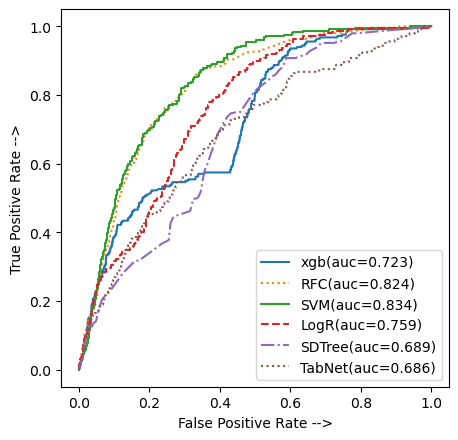

In [18]:
#Plot AUC
xgb_fpr, xgb_tpr, threshold = metrics.roc_curve(y, prob_test_final_XGB)
RFC_fpr, RFC_tpr, threshold = metrics.roc_curve(y, prob_test_final_RFC)
SVM_fpr, SVM_tpr, threshold = metrics.roc_curve(y, prob_test_final_SVM)
LogR_fpr, LogR_tpr, threshold = metrics.roc_curve(y, prob_test_final_LogR)
SDTree_fpr, SDTree_tpr, threshold = metrics.roc_curve(y, prob_test_final_SDTree)
TabNet_fpr, TabNet_tpr, threshold = metrics.roc_curve(y, prob_test_final_TabNet)

auc_xgb = metrics.auc(xgb_fpr, xgb_tpr)
auc_RFC_test = metrics.auc(RFC_fpr, RFC_tpr)
auc_SVM_test = metrics.auc(SVM_fpr, SVM_tpr)
auc_LogR_test = metrics.auc(LogR_fpr, LogR_tpr)
auc_SDTree_test = metrics.auc(SDTree_fpr, SDTree_tpr)
auc_TabNet_test = metrics.auc(TabNet_fpr, TabNet_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label='xgb(auc=%0.3f)' % auc_xgb)
plt.plot(RFC_fpr, RFC_tpr, linestyle='dotted', label='RFC(auc=%0.3f)' % auc_RFC_test)
plt.plot(SVM_fpr, SVM_tpr, linestyle='solid', label='SVM(auc=%0.3f)' % auc_SVM_test)
plt.plot(LogR_fpr, LogR_tpr, linestyle='dashed', label='LogR(auc=%0.3f)' % auc_LogR_test)
plt.plot(SDTree_fpr, SDTree_tpr, linestyle='dashdot', label='SDTree(auc=%0.3f)' % auc_SDTree_test)
plt.plot(TabNet_fpr, TabNet_tpr, linestyle=':', label='TabNet(auc=%0.3f)' % auc_TabNet_test)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()